# Starting anew to clean up

In [1]:
import caesar
import numpy as np
import astropy
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable, Table, Column
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats
import seaborn as sns

/home/sarah/anaconda3/lib/python3.9/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/sarah/.config/yt/ytrc is deprecated in favor of /home/sarah/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


#### To find the x-ray luminosity we must find the bolometric luminosities first:

Finding Bolometric Luminosity (from Habouzit 2022):
* for $f_{edd} > 0.1$ we use $L_{bol} = \frac{\epsilon_r}{1-\epsilon_r}\dot{M_{bh}}c^2$ 
* for $f_{edd} < 0.1$ we use $L_{bol} = (10 f_{edd})\epsilon_r \dot{M_{bh}}c^2$

#### Then apply the bolometeric correction:

Hard X-ray luminosities are computed by applying a bolometric correction, BC (from Hopkins, Richards & Hernquist 2007):

$BC = 10.83 \left( \frac{L_{bol,\odot}}{10^{10} L_{\odot}}\right)^{0.28} + 6.08 \left(\frac{L_{bol,\odot}}{10^{10} L_{\odot}}\right)^{-0.02}$

$\log_{10} L_{2-10keV,\odot} = \log_{10} L_{bol,\odot} - \log_{10} BC$

### Methods to gather the wanted data

In [2]:
def get_xray_luminosity(obj):
    ''' 
    Returns the non-zero x-ray luminosity for every galaxy in the input file

        Parameters:
                obj : Caesar read infile
                      

        Returns:
                Lx : array_like
                     An array of X-ray luminosities
    '''

    # get an array of all bhmdot and bh_fedd
    accretion_rates = [i.bhmdot for i in obj.galaxies]
    eddington_ratio = [i.bh_fedd for i in obj.galaxies]

    # extract data into array
    bhmdot0 = np.array(accretion_rates)
    bh_fedd = np.array(eddington_ratio)
    
    # removing the 0 accretion rates because they give Lx = 0
    bhmdot = bhmdot0[bhmdot0 !=0]
    bh_fedd = bh_fedd[bhmdot0 !=0]
    
    # finding the bolometric luminosities
    # array with shape bhmdot of Lbols using the first equation (fedd > 0.1) for all values
    Er = 0.1
    Lbol = ((Er/(1-Er))*bhmdot*(u.M_sun/u.yr)*(const.c**2))
    Lbol2 = ((Er/(1-Er))*bhmdot*(u.M_sun/u.yr)*(const.c**2))
    
    # replacing the indices where fedd < 0.1 with values using the other equation
    # this retains the units
    Lbol[bh_fedd < 0.1] = (10*bh_fedd[bh_fedd < 0.1])*Er*bhmdot[bh_fedd < 0.1]*(u.M_sun/u.yr)*(const.c**2)
    
    # finds the bolometric correction
    BC = 10.83*((Lbol.to('L_sun')/(10**(10)*u.L_sun))**(0.28)) + 6.08*((Lbol.to('L_sun')/(10**(10)*u.L_sun))**(-0.02))
    BC2 = 10.83*((Lbol2.to('L_sun')/(10**(10)*u.L_sun))**(0.28)) + 6.08*((Lbol2.to('L_sun')/(10**(10)*u.L_sun))**(-0.02))
    
    # finding the hard x-ray luminosity in terms of Lsun
    # have to use just the value of Lbol_sun then add it back on because np.log10 only works on dimensionless quantities
    # it then converts to erg/s
    Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
    Lx_ergs2 = ((10**(np.log10(Lbol2.to('L_sun').value)-np.log10(BC2)))*u.L_sun).to('erg/s')
    
    #making it unitless
    Lx = Lx_ergs.value
    Lx2 = Lx_ergs2.value

    
    return Lx, Lx2

In [3]:
def get_non_zeros(obj):
    '''
    Returns an array of indices representing the positions in an array that correspond to values of black hole
    accretion rates that are non-zero
   
        Parameters:
                obj : Caesar read infile
                      

        Returns:
                ind : array_like
                      An array of indices where black hole accretion rate is non-zero
    '''

    # get an array of all bhmdot and bh_fedd
    accretion_rates = [i.bhmdot for i in obj.galaxies]

    # extract data into array
    bhmdot0 = np.array(accretion_rates)
    
    # removing the 0 accretion rates because they give Lx = 0
    ind = (bhmdot0 !=0 )
    
    return ind

In [4]:
def get_stellar_mass(obj, ind):
    '''
    Returns the stellar mass for every galaxy in the input file

        Parameters:
                obj : Caesar read infile
                ind : array_like
                      An array of indices where black hole accretion rate is non-zero
                      

        Returns:
                stellar_mass : array_like
                               An array of stellar masses
    '''

    # get an array of all galaxy masses
    galaxy_masses = [i.masses['stellar'] for i in obj.galaxies]

    # extract data into array
    stellar_mass = np.array(galaxy_masses)
    stellar_mass = stellar_mass[ind]
    
    return stellar_mass



In [5]:
def get_SFR(obj, ind):
    '''
    Returns the star formation rate for every galaxy in the input file

        Parameters:
                obj : Caesar read infile
                ind : array_like
                      An array of indices where black hole accretion rate is non-zero
                      

        Returns:
                SFR : array_like
                      An array of star formation rates
    '''

    # get an array of all galaxy masses
    galaxy_SFRs = [i.sfr for i in obj.galaxies]

    # extract data into array
    SFR = np.array(galaxy_SFRs)
    SFR = SFR[ind]
    
    return SFR



In [6]:
def get_bh_mass(obj, ind):
    '''
    Returns the black hole mass for every galaxy with an AGN (Mdot > 0) in the input file

        Parameters:
                obj : Caesar read infile
                ind : array_like
                      An array of indices where black hole accretion rate is non-zero
                      

        Returns:
                bh_mass : array_like
                          An array of black hole masses
    '''

    # get an array of all galaxy masses
    bh_masses = [i.masses['bh'] for i in obj.galaxies]

    # extract data into array
    bh_mass = np.array(bh_masses)
    bh_mass = bh_mass[ind]
    
    return bh_mass

In [7]:
def get_ALL_Lx(obj):
    ''' 
    Returns the x-ray luminosity for every galaxy in the input file

        Parameters:
                obj : Caesar read infile
                      

        Returns:
                Lx : array_like
                     An array of X-ray luminosities
    '''

    # get an array of all bhmdot and bh_fedd
    accretion_rates = [i.bhmdot for i in obj.galaxies]
    eddington_ratio = [i.bh_fedd for i in obj.galaxies]

    # extract data into array
    bhmdot = np.array(accretion_rates)
    bh_fedd = np.array(eddington_ratio)
    
    # finding the bolometric luminosities
    # array with shape bhmdot of Lbols using the first equation (fedd > 0.1) for all values
    Er = 0.1
    Lbol = ((Er/(1-Er))*bhmdot*(u.M_sun/u.yr)*(const.c**2))
    
    # replacing the indices where fedd < 0.1 with values using the other equation
    # this retains the units
    Lbol[bh_fedd < 0.1] = (10*bh_fedd[bh_fedd < 0.1])*Er*bhmdot[bh_fedd < 0.1]*(u.M_sun/u.yr)*(const.c**2)
    
    # finds the bolometric correction
    BC = 10.83*((Lbol.to('L_sun')/(10**(10)*u.L_sun))**(0.28)) + 6.08*((Lbol.to('L_sun')/(10**(10)*u.L_sun))**(-0.02))
    
    # finding the hard x-ray luminosity in terms of Lsun
    # have to use just the value of Lbol_sun then add it back on because np.log10 only works on dimensionless quantities
    # it then converts to erg/s
    Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
    
    #making it unitless
    Lx = Lx_ergs.value
    
    return Lx

In [8]:
def get_properties(obj):
    ''' 
    Returns the properties x-ray luminosities, stellar mass, star formation rate, specific star formation rate, 
    black hole mass, and lambda for every galaxy in the input file with stellar mass greater than 10^10 solar masses

        Parameters:
                obj : Caesar read infile
                      

        Returns:
                          Lx : array_like
                               An array of x-ray luminosities
                stellar_mass : array_like
                               An array of stellar masses
                         SFR : array_like
                               An array of star formation rates
                        sSFR : array_like
                               An array of specific star formation rates
                     bh_mass : array_like
                               An array of black hole masses
                       lmbda : array_like
                               An array of lambda
    '''
    
    # get Lx
    # get an array of all bhmdot and bh_fedd
    accretion_rates = [i.bhmdot for i in obj.galaxies]
    eddington_ratio = [i.bh_fedd for i in obj.galaxies]

    # extract data into array
    bhmdot = np.array(accretion_rates)
    bh_fedd = np.array(eddington_ratio)
    
    # finding the bolometric luminosities
    # array with shape bhmdot of Lbols using the first equation (fedd > 0.1) for all values
    Er = 0.1
    Lbol = ((Er/(1-Er))*bhmdot*(u.M_sun/u.yr)*(const.c**2))
    
    # replacing the indices where fedd < 0.1 with values using the other equation
    # this retains the units
    Lbol[bh_fedd < 0.1] = (10*bh_fedd[bh_fedd < 0.1])*Er*bhmdot[bh_fedd < 0.1]*(u.M_sun/u.yr)*(const.c**2)
    
    # finds the bolometric correction
    BC = 10.83*((Lbol.to('L_sun')/(10**(10)*u.L_sun))**(0.28)) + 6.08*((Lbol.to('L_sun')/(10**(10)*u.L_sun))**(-0.02))
    
    # finding the hard x-ray luminosity in terms of Lsun
    # have to use just the value of Lbol_sun then add it back on because np.log10 only works on dimensionless quantities
    # it then converts to erg/s
    Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
    
    #making it unitless
    Lx = Lx_ergs.value
    
    
    
    
    # extract galaxy mass data
    galaxy_masses = [i.masses['stellar'] for i in obj.galaxies]
    all_sm = np.array(galaxy_masses)
    sm_gt10 = (all_sm > 10**10)
    stellar_mass = all_sm[sm_gt10]
    
    # masking Lx for corresponding stellar masses > 10^10
    Lx = Lx[sm_gt10]
    
    # extract star formation rates data
    galaxy_SFRs = [i.sfr for i in obj.galaxies]
    SFR = np.array(galaxy_SFRs)
    SFR = SFR[sm_gt10]
    
    # extract black hole mass data
    bh_masses = [i.masses['bh'] for i in obj.galaxies]
    bh_mass = np.array(bh_masses)
    bh_mass = bh_mass[sm_gt10]
    
    # calculate specific star formation rate
    sSFR = SFR/stellar_mass
    
    # calculating lambda
    lmbda = 25.0*Lx / (1.3e38*0.002*stellar_mass)  
    
    
    return Lx, stellar_mass, SFR, sSFR, bh_mass, lmbda

In [9]:
def get_properties0(obj):
    ''' 
    Returns the properties stellar mass, star formation rate, specific star formation rate, black hole mass, and lambda
    for every galaxy in the input file

        Parameters:
                obj : Caesar read infile
                      

        Returns:
                stellar_mass : array_like
                               An array of stellar masses
                         SFR : array_like
                               An array of star formation rates
                        sSFR : array_like
                               An array of specific star formation rates
                     bh_mass : array_like
                               An array of black hole masses
                       lmbda : array_like
                               An array of lambda
    '''
    
    # get Lx
    Lx = get_ALL_Lx(obj)
    
    # extract galaxy mass data
    galaxy_masses = [i.masses['stellar'] for i in obj.galaxies]
    stellar_mass = np.array(galaxy_masses)
    
    # extract star formation rates data
    galaxy_SFRs = [i.sfr for i in obj.galaxies]
    SFR = np.array(galaxy_SFRs)
    
    # extract black hole mass data
    bh_masses = [i.masses['bh'] for i in obj.galaxies]
    bh_mass = np.array(bh_masses)
    
    # calculate specific star formation rate
    sSFR = SFR/stellar_mass
    
    # calculating lambda
    lmbda = 25.0*Lx / (1.3e38*0.002*stellar_mass)
    
    return stellar_mass, SFR, sSFR, bh_mass, lmbda

yt : [INFO     ] 2023-01-05 14:01:00,774 Opening /disk04/rad/sim/m25n256/s50/Groups/m25n256_137.hdf5
yt : [INFO     ] 2023-01-05 14:01:01,300 Found 7848 halos
yt : [INFO     ] 2023-01-05 14:01:02,059 Found 841 galaxies
/home/sarah/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_2157244/2979682850.py:49: RuntimeWarning: divide by zero encountered in log10
  Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
/tmp/ipykernel_2157244/2713877146.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(SFR), np.log10(Lx), '.')


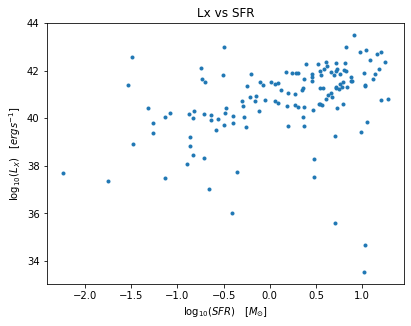

/tmp/ipykernel_2157244/2713877146.py:19: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(sSFR), np.log10(Lx), '.')


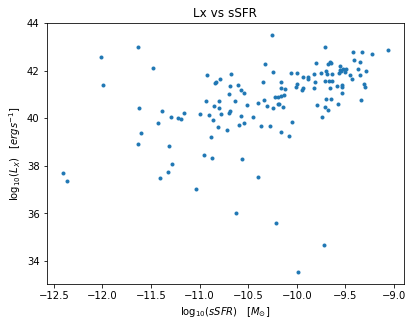

/tmp/ipykernel_2157244/2713877146.py:25: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(sm), np.log10(Lx), '.')


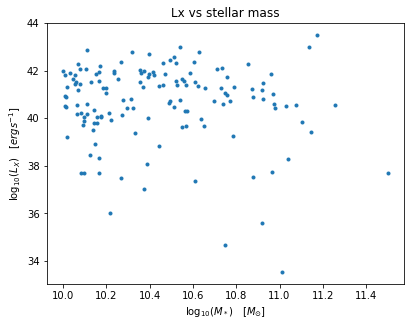

In [10]:
folder_path = '/disk04/rad/sim/m25n256/s50/Groups/'
filename = 'm25n256_137.hdf5'
obj = caesar.load(os.path.join(folder_path, filename))

#Lx, Lx2 = get_xray_luminosity(obj)
#ind = get_non_zeros(obj)
#stellar_mass = get_stellar_mass(obj, ind)
#SFR = get_SFR(obj, ind)
#sSFR = SFR/stellar_mass
Lx, sm, SFR, sSFR, bhm, lmbda = get_properties(obj)

plt.rcParams["figure.figsize"] = (6.4,4.8)
plt.plot(np.log10(SFR), np.log10(Lx), '.')
plt.xlabel('$\log_{10}(SFR) \quad [M_{\odot}]$')
plt.ylabel('$\log_{10}(L_X) \quad [erg s^{-1}]$')
plt.title('Lx vs SFR')
plt.show()

plt.plot(np.log10(sSFR), np.log10(Lx), '.')
plt.xlabel('$\log_{10}(sSFR) \quad [M_{\odot}]$')
plt.ylabel('$\log_{10}(L_X) \quad [erg s^{-1}]$')
plt.title('Lx vs sSFR')
plt.show()

plt.plot(np.log10(sm), np.log10(Lx), '.')
plt.xlabel('$\log_{10}(M_*) \quad [M_{\odot}]$')
plt.ylabel('$\log_{10}(L_X) \quad [erg s^{-1}]$')
plt.title('Lx vs stellar mass')
plt.show()

#### We need to bin the data in order to replicate plots

The redshift binning used in Aird 2016 are:

* $0.1 < z < 0.5$
* $0.5 < z < 1.0$
* $1.0 < z < 1.5$
* $1.5 < z < 2.0$
* $2.0 < z < 2.5$
* $2.5 < z < 3.0$
* $3.0 < z < 4.0$

and the stellar mass binning is:

* $8.5 < \log(M_* / M_{\odot}) < 9.0$
* $9.0 < \log(M_* / M_{\odot}) < 9.5$
* $9.5 < \log(M_* / M_{\odot}) < 10.0$
* $10.0 < \log(M_* / M_{\odot}) < 10.5$
* $10.5 < \log(M_* / M_{\odot}) < 11.0$
* $11.0 < \log(M_* / M_{\odot}) < 11.5$

Black holes in simba are seeded at $10^{9.5} M_* / M_{\odot} $ so between $9.5 < \log(M_* / M_{\odot}) < 10.0$ they grow rapidly, creating huge amounts of x-ray luminosity. To prevent anomolous galaxies therefore, we must create a stellar mass cut-off minimum of $10^{10.0} M_* / M_{\odot}$. Additionally, the mass bins will be adjusted so that there are enough galaxies in each in order to form a histogram.

We will choose one redshift snapshop for each redshift bin so that there are no galaxy overlaps in simba. They are chosen as they have redshifts as close to the middle of the redshift bin as possible.
The chosen files are:

* m25n256_66.hdf5
* m25n256_74.hdf5
* m25n256_84.hdf5
* m25n256_97.hdf5
* m25n256_114.hdf5
* m25n256_137.hdf5

In [11]:
# a list of the different redshifted files I want to load (box size 25)
files = [
'm25n256_066.hdf5',
'm25n256_074.hdf5',
'm25n256_084.hdf5',
'm25n256_097.hdf5',
'm25n256_114.hdf5',
'm25n256_137.hdf5']
files.reverse()

In [12]:
# need to add 'm25n256_056.hdf5' to the above

In [13]:
# a list of the different redshifted files I want to load (box size 100)
files = ['m100n1024_056.hdf5',
'm100n1024_066.hdf5',
'm100n1024_074.hdf5',
'm100n1024_084.hdf5',
'm100n1024_097.hdf5',
'm100n1024_114.hdf5',
'm100n1024_137.hdf5']
files.reverse()

#### Iterating across the filenames (redshifts) and extracting the data into astropy tables
(Lx2 is the Lx where we only use the first equation to calculate it (ignoring the 10fedd term))

In [14]:

# define input file
# box 25
#folder_path = '/disk04/rad/sim/m25n256/s50/Groups/' 
#box 100
folder_path = '/disk04/rad/sim/m100n1024/s50/Groups/'

# empty dictionary to place redshift table data into
r = {}

for filename in files:
    # load in input file
    obj = caesar.load(os.path.join(folder_path, filename))
    
    # obtaining Lx
    Lx, Lx2 = get_xray_luminosity(obj)
    
    # obtaining stellar mass
    ind = get_non_zeros(obj)
    sm = get_stellar_mass(obj, ind)
    
    # obtaining star formation rate and specific SFR
    SFR = get_SFR(obj, ind)
    sSFR = SFR/sm
    
    # obtaining bh mass
    bhm = get_bh_mass(obj, ind)
    
    # calculating lambda
    lmbda = 25.0*Lx / (1.3e38*0.002*sm)
    
    # finding the z label
    label = filename.split('m100n1024_')[1].split('.hdf5')[0]
    
    # creating a table for each redshift, putting it in the empty dictionary, and naming them
    name = str('z') + str(label)
    r[name] = astropy.table.Table([Lx, Lx2, sm, SFR, sSFR, bhm, lmbda], names=('Lx', 'Lx2', 'sm', 'SFR', 'sSFR', 'bhm', 'lambda'))
    

    

yt : [INFO     ] 2023-01-05 14:01:03,986 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_137.hdf5
yt : [INFO     ] 2023-01-05 14:01:04,754 Found 482650 halos
yt : [INFO     ] 2023-01-05 14:01:06,400 Found 49752 galaxies
yt : [INFO     ] 2023-01-05 14:01:11,675 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_114.hdf5
yt : [INFO     ] 2023-01-05 14:01:12,566 Found 517907 halos
yt : [INFO     ] 2023-01-05 14:01:14,947 Found 41585 galaxies
yt : [INFO     ] 2023-01-05 14:01:20,498 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_097.hdf5
yt : [INFO     ] 2023-01-05 14:01:21,335 Found 539783 halos
yt : [INFO     ] 2023-01-05 14:01:23,000 Found 37280 galaxies
yt : [INFO     ] 2023-01-05 14:01:25,853 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_084.hdf5
yt : [INFO     ] 2023-01-05 14:01:26,622 Found 547198 halos
yt : [INFO     ] 2023-01-05 14:01:28,774 Found 33282 galaxies
yt : [INFO     ] 2023-01-05 14:01:32,379 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1

#### Making a new table for all the galaxies, not just ones with AGN, in order to find AGN fraction.
Later on, where I only want AGN, I can mask this table for non-zero Lx, then only use this one from then on.

In [15]:

# define input file
# box 25
#folder_path = '/disk04/rad/sim/m25n256/s50/Groups/' 
#box 100
folder_path = '/disk04/rad/sim/m100n1024/s50/Groups/'

# empty dictionary to place redshift table data into
all_r = {}

for filename in files:
    # load in input file
    obj = caesar.load(os.path.join(folder_path, filename))
    
    # obtaining the properties
    Lx, sm, SFR, sSFR, bhm, lmbda = get_properties(obj)
    
    # finding the z label
    label = filename.split('m100n1024_')[1].split('.hdf5')[0]
    
    # creating a table for each redshift, putting it in the empty dictionary, and naming them
    name = str('z') + str(label)
    all_r[name] = astropy.table.Table([Lx, sm, SFR, sSFR, bhm, lmbda], names=('Lx', 'sm', 'SFR', 'sSFR', 'bhm', 'lambda'))
    

    

yt : [INFO     ] 2023-01-05 14:01:48,397 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_137.hdf5
yt : [INFO     ] 2023-01-05 14:01:48,437 Found 482650 halos
yt : [INFO     ] 2023-01-05 14:01:48,451 Found 49752 galaxies
/home/sarah/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_2157244/2979682850.py:49: RuntimeWarning: divide by zero encountered in log10
  Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
yt : [INFO     ] 2023-01-05 14:01:51,342 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_114.hdf5
yt : [INFO     ] 2023-01-05 14:01:51,398 Found 517907 halos
yt : [INFO     ] 2023-01-05 14:01:51,413 Found 41585 galaxies
yt : [INFO     ] 2023-01-05 14:01:55,739 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_097.hdf5
yt : [INFO     ] 2023-01-05 14:01:55,787 Found 539783 h

In [16]:
def get_all_r():
    # define input file
    # box 25
    #folder_path = '/disk04/rad/sim/m25n256/s50/Groups/' 
    #box 100
    folder_path = '/disk04/rad/sim/m100n1024/s50/Groups/'

    # empty dictionary to place redshift table data into
    all_r = {}

    for filename in files:
        # load in input file
        obj = caesar.load(os.path.join(folder_path, filename))

        # obtaining the properties
        Lx, sm, SFR, sSFR, bhm, lmbda = get_properties(obj)

        # finding the z label
        label = filename.split('m100n1024_')[1].split('.hdf5')[0]

        # creating a table for each redshift, putting it in the empty dictionary, and naming them
        name = str('z') + str(label)
        all_r[name] = astropy.table.Table([Lx, sm, SFR, sSFR, bhm, lmbda], names=('Lx', 'sm', 'SFR', 'sSFR', 'bhm', 'lambda'))
        
    return all_r
    

    

In [17]:
# call the correct table this way:
# print(r['z137'])

# extract the data you want using:
# print(r['z137']['Lx'])

#### Binning the data based on stellar mass

In [18]:
Lx_med = []
Lx_av = []
#Lx_med2 = []

for key in r:
    
    # OLD WAY: creating the masks to bin the stellar masses
    # there should be no galaxies greater than 10^11.5 so the upper most bin is just > 10^11
    #m10_10 = (r[key]['sm'] > (1e10)) & (r[key]['sm'] <= 10**(10.5))
    #m10_11 = (r[key]['sm'] > 10**10.5) & (r[key]['sm'] <= 1e11)
    #m11 = (r[key]['sm'] > 1e11)
    
    # NEW WAY: binning the mass data
    bins = np.array([10, 10.5, 11, np.inf])
    digitized = np.digitize(np.log10(r[key]['sm']), bins)
    
    # finding avergae Lx for binned data
    Lx_avnew = np.array([np.mean(r[key]['Lx'][digitized == i]) for i in range(1, len(bins))])
    Lx_av.append(Lx_avnew)
    
    # finding median Lx for binned data
    Lx_mednew = np.array([np.median(r[key]['Lx'][digitized == i]) for i in range(1, len(bins))])
    Lx_med.append(Lx_mednew)   
    
    # Adding a second for different bolometric L calculation (dashed lines)
    #Lx20 = np.array([np.median(r[key]['Lx2'][m10_10]),
    #               np.median(r[key]['Lx2'][m10_11]),
    #               np.median(r[key]['Lx2'][m11])])
    #Lx_med2.append(Lx20)
    
    
Lx_med = np.asarray(Lx_med)
Lx_av = np.asarray(Lx_av)
#Lx_med2 = np.asarray(Lx_med2)  

In [19]:
# to double check
print(Lx_av)
print(Lx_med)

[[5.63111769e+41 8.55144038e+41 1.95769677e+42]
 [3.15462242e+42 3.29670025e+42 9.18651081e+42]
 [7.35641986e+42 1.01453853e+43 1.38113349e+43]
 [1.08592215e+43 1.82198614e+43 3.84696779e+43]
 [1.43704050e+43 2.74695424e+43 5.91049515e+43]
 [1.51743246e+43 3.24569081e+43 5.84841511e+43]
 [1.72157693e+43 4.97632544e+43 6.10123033e+43]]
[[5.92662841e+40 1.52397597e+41 9.67367575e+40]
 [4.56842119e+41 6.99389922e+41 5.13516985e+41]
 [3.32889681e+42 3.55191718e+42 1.48025328e+42]
 [6.37994960e+42 7.92841619e+42 5.88365917e+42]
 [9.38059094e+42 1.49496115e+43 1.80121374e+43]
 [1.02279206e+43 1.93652035e+43 2.84209632e+43]
 [1.30453803e+43 3.93828064e+43 3.26789163e+43]]


#### Replicating figure 3 from xatgp iii

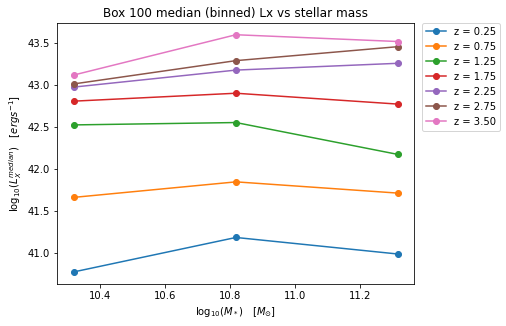

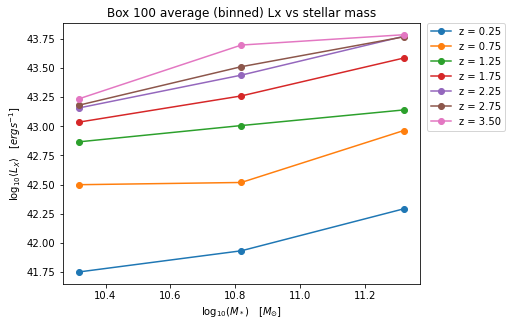

In [20]:
# midpoint of each mass bin as x values
sm_med = np.array([np.mean([10**10, 10**10.5]), np.mean([10**10.5, 10**11]), np.mean([10**11, 10**11.5])])

plt.plot(np.log10(sm_med), np.log10(Lx_med[0]), '-o', label='z = 0.25')
plt.plot(np.log10(sm_med), np.log10(Lx_med[1]), '-o', label='z = 0.75')
plt.plot(np.log10(sm_med), np.log10(Lx_med[2]), '-o', label='z = 1.25')
plt.plot(np.log10(sm_med), np.log10(Lx_med[3]), '-o', label='z = 1.75')
plt.plot(np.log10(sm_med), np.log10(Lx_med[4]), '-o', label='z = 2.25')
plt.plot(np.log10(sm_med), np.log10(Lx_med[5]), '-o', label='z = 2.75')
plt.plot(np.log10(sm_med), np.log10(Lx_med[6]), '-o', label='z = 3.50')

#plt.plot(np.log10(sm_med), np.log10(Lx_med2[0]), 'r--o', label='z = 0.25')
#plt.plot(np.log10(sm_med), np.log10(Lx_med2[1]), 'y--o', label='z = 0.75')
#plt.plot(np.log10(sm_med), np.log10(Lx_med2[2]), 'b--o', label='z = 1.25')
#plt.plot(np.log10(sm_med), np.log10(Lx_med2[3]), 'g--o', label='z = 1.75')
#plt.plot(np.log10(sm_med), np.log10(Lx_med2[4]), 'm--o', label='z = 2.25')
#plt.plot(np.log10(sm_med), np.log10(Lx_med2[5]), 'k--o', label='z = 2.75')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
plt.xlabel('$\log_{10}(M_*) \quad [M_{\odot}]$')
plt.ylabel('$\log_{10}(L_{X}^{median}) \quad [erg s^{-1}]$')
plt.title('Box 100 median (binned) Lx vs stellar mass')
plt.show()

plt.plot(np.log10(sm_med), np.log10(Lx_av[0]), '-o', label='z = 0.25')
plt.plot(np.log10(sm_med), np.log10(Lx_av[1]), '-o', label='z = 0.75')
plt.plot(np.log10(sm_med), np.log10(Lx_av[2]), '-o', label='z = 1.25')
plt.plot(np.log10(sm_med), np.log10(Lx_av[3]), '-o', label='z = 1.75')
plt.plot(np.log10(sm_med), np.log10(Lx_av[4]), '-o', label='z = 2.25')
plt.plot(np.log10(sm_med), np.log10(Lx_av[5]), '-o', label='z = 2.75')
plt.plot(np.log10(sm_med), np.log10(Lx_av[6]), '-o', label='z = 3.50')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
plt.xlabel('$\log_{10}(M_*) \quad [M_{\odot}]$')
plt.ylabel(r'$\log_{10}\langle L_{X} \rangle \quad [erg s^{-1}]$')
plt.title('Box 100 average (binned) Lx vs stellar mass')
plt.show()

#### Finding the density of the mass bins

In [21]:
for key in r:    
    # creating the masks to bin the stellar masses
    # there should be no galaxies greater than 10^11.5 so the upper most bin is just > 10^11
    m10_10 = (r[key]['sm'] > (1e10)) & (r[key]['sm'] <= 10**(10.5))
    m10_11 = (r[key]['sm'] > 10**10.5) & (r[key]['sm'] <= 1e11)
    m11 = (r[key]['sm'] > 1e11)
    
    print(key)
    print('m10_10:  ' + str(np.size(r[key]['Lx'][m10_10])))
    print('m10_11:  ' + str(np.size(r[key]['Lx'][m10_11])))
    print('m11:  ' + str(np.size(r[key]['Lx'][m11])))
    print('\n')
    

z137
m10_10:  5262
m10_11:  1583
m11:  228


z114
m10_10:  4881
m10_11:  1901
m11:  321


z097
m10_10:  3368
m10_11:  1598
m11:  376


z084
m10_10:  1983
m10_11:  1025
m11:  365


z074
m10_10:  1249
m10_11:  636
m11:  233


z066
m10_10:  778
m10_11:  353
m11:  141


z056
m10_10:  378
m10_11:  182
m11:  52




#### Attempting a probability distribution

Text(0, 0.5, 'p(log10(Lx))')

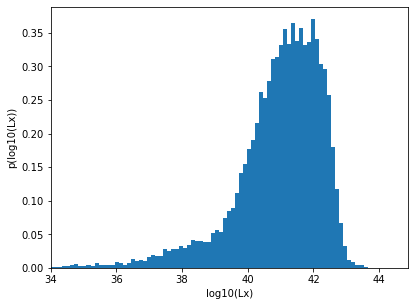

In [22]:
#print(np.histogram(r['z137']['Lx'], bins=100))
#print(np.log(r['z137']['Lx']))
#plt.plot(r['z137']['Lx'], np.histogram(r['z137']['Lx']))
plt.hist(np.log10(r['z137']['Lx']), bins=200,density=True)
plt.xlim(left=34)
plt.xlabel('log10(Lx)')
plt.ylabel('p(log10(Lx))')

Text(0, 0.5, 'p(log10(Lx))')

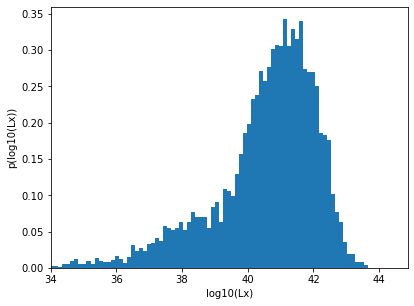

In [23]:
# plotting this for only Lx's that have mass over cap
m10_10 = (r['z137']['sm'] > (1e10))
plt.hist(np.log10(r['z137']['Lx'][m10_10]), bins=200,density=True)
plt.xlim(left=34)
plt.xlabel('log10(Lx)')
plt.ylabel('p(log10(Lx))')

#### Replicating figure 8 from xatgp ii

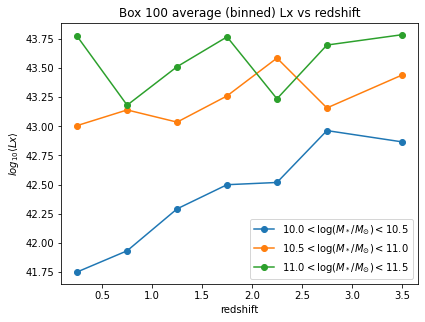

In [24]:
Lx_avplot = np.reshape(Lx_av, (3,7))
redshifts = np.array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.5])

plt.plot(redshifts, np.log10(Lx_avplot[0]), '-o', label='$10.0 < \log(M_* / M_{\odot}) < 10.5$')
plt.plot(redshifts, np.log10(Lx_avplot[1]), '-o', label='$10.5 < \log(M_* / M_{\odot}) < 11.0$')
plt.plot(redshifts, np.log10(Lx_avplot[2]), '-o', label='$11.0 < \log(M_* / M_{\odot}) < 11.5$')
plt.xlabel('redshift')
plt.ylabel(r'$ log_{10}\langle Lx \rangle $')
plt.title('Box 100 average (binned) Lx vs redshift')
plt.legend()
plt.show()

#### Binning the data based on SFR

In [25]:
Lx_med = []
Lx_av = []

for key in r:

    # NEW WAY: binning the mass data
    bins = np.array([-2.5, -1, -0.5, 0, 0.5, 1, np.inf])
    digitized = np.digitize(np.log10(r[key]['SFR']), bins)
    
    # finding avergae Lx for binned data
    Lx_avnew = np.array([np.mean(r[key]['Lx'][digitized == i]) for i in range(1, len(bins))])
    Lx_av.append(Lx_avnew)
    
    # finding median Lx for binned data
    Lx_mednew = np.array([np.median(r[key]['Lx'][digitized == i]) for i in range(1, len(bins))])
    Lx_med.append(Lx_mednew)   
    
Lx_med = np.asarray(Lx_med)
Lx_av = np.asarray(Lx_av)

/tmp/ipykernel_2157244/3993490487.py:8: RuntimeWarning: divide by zero encountered in log10
  digitized = np.digitize(np.log10(r[key]['SFR']), bins)
/home/sarah/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/sarah/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Replicating figure 4 from xatgp iii

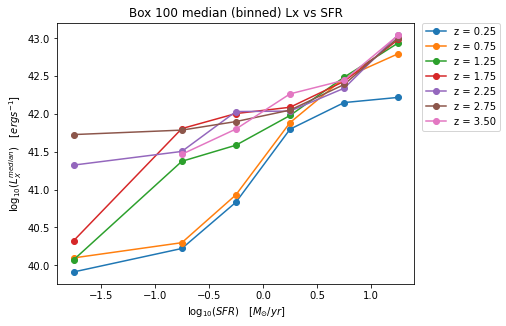

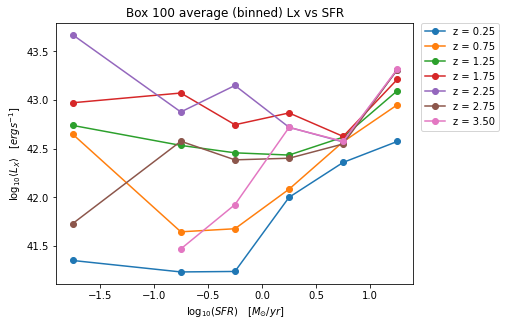

In [26]:
SFR_bins = np.array([-1.75, -0.75, -0.25, 0.25, 0.75, 1.25])

plt.plot(SFR_bins, np.log10(Lx_med[0]), '-o', label='z = 0.25')
plt.plot(SFR_bins, np.log10(Lx_med[1]), '-o', label='z = 0.75')
plt.plot(SFR_bins, np.log10(Lx_med[2]), '-o', label='z = 1.25')
plt.plot(SFR_bins, np.log10(Lx_med[3]), '-o', label='z = 1.75')
plt.plot(SFR_bins, np.log10(Lx_med[4]), '-o', label='z = 2.25')
plt.plot(SFR_bins, np.log10(Lx_med[5]), '-o', label='z = 2.75')
plt.plot(SFR_bins, np.log10(Lx_med[6]), '-o', label='z = 3.50')

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
plt.xlabel('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
plt.ylabel('$\log_{10}(L_{X}^{median}) \quad [erg s^{-1}]$')
plt.title('Box 100 median (binned) Lx vs SFR')
plt.show()

plt.plot(SFR_bins, np.log10(Lx_av[0]), '-o', label='z = 0.25')
plt.plot(SFR_bins, np.log10(Lx_av[1]), '-o', label='z = 0.75')
plt.plot(SFR_bins, np.log10(Lx_av[2]), '-o', label='z = 1.25')
plt.plot(SFR_bins, np.log10(Lx_av[3]), '-o', label='z = 1.75')
plt.plot(SFR_bins, np.log10(Lx_av[4]), '-o', label='z = 2.25')
plt.plot(SFR_bins, np.log10(Lx_av[5]), '-o', label='z = 2.75')
plt.plot(SFR_bins, np.log10(Lx_av[6]), '-o', label='z = 3.50')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
plt.xlabel('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
plt.ylabel(r'$\log_{10}\langle L_{X} \rangle \quad [erg s^{-1}]$')
plt.title('Box 100 average (binned) Lx vs SFR')
plt.show()

#### Looking into bh mass evolution

/tmp/ipykernel_2157244/1240252571.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_vals = np.asarray(x_vals)


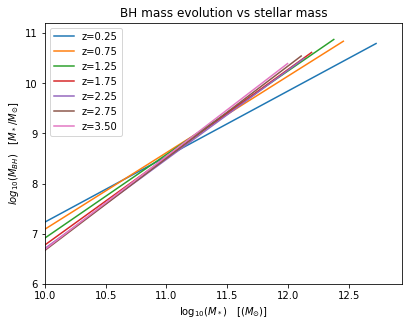

In [27]:
x_vals = []
z = []
for key in r:
    x = np.array(np.log10(r[key]['sm']))
    x_vals.append(x)
    y = np.log10(r[key]['bhm'])
    z.append(np.polyfit(x, y, 1))
    
x_vals = np.asarray(x_vals)
z = np.asarray(z)
#print(x_vals)
plt.plot(x_vals[0], np.poly1d(z[0])(x_vals[0]), label='z=0.25')
plt.plot(x_vals[1], np.poly1d(z[1])(x_vals[1]), label='z=0.75')
plt.plot(x_vals[2], np.poly1d(z[2])(x_vals[2]), label='z=1.25')
plt.plot(x_vals[3], np.poly1d(z[3])(x_vals[3]), label='z=1.75')
plt.plot(x_vals[4], np.poly1d(z[4])(x_vals[4]), label='z=2.25')
plt.plot(x_vals[5], np.poly1d(z[5])(x_vals[5]), label='z=2.75')
plt.plot(x_vals[6], np.poly1d(z[6])(x_vals[6]), label='z=3.50')
plt.xlim(left=10)
plt.ylim(bottom=6)
plt.ylabel('$log_{10}(M_{BH}) \quad [M_* / M_{\odot}]$')
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.title('BH mass evolution vs stellar mass')
plt.legend()
plt.show()
#print(np.poly1d(z[0])(x_vals[0]))
    
#p = np.poly1d(z)

#### stellar mass vs SFR

In [28]:
sfr = all_r['z137']['SFR']
logsfr = np.log10(sfr[sfr != 0])

sm = all_r['z137']['sm'][sfr != 0]
logsm = np.log10(sm)

Lx = all_r['z137']['Lx'][sfr != 0]
#print(Lx)
for i in range(len(Lx)):
    if Lx[i] == 0:
        Lx[i] = 1e-1
        
logLx = np.log10(Lx)
#print(Lx)

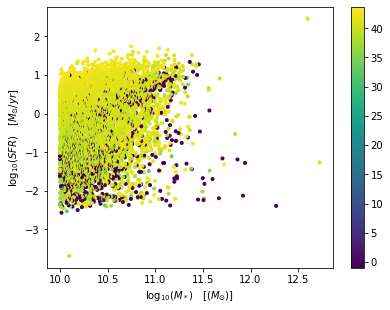

In [29]:

plt.scatter(logsm, logsfr, c=logLx, marker='.')
#plt.xlim(left=10)
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
plt.colorbar()
plt.show()

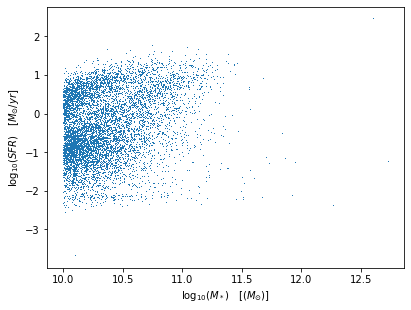

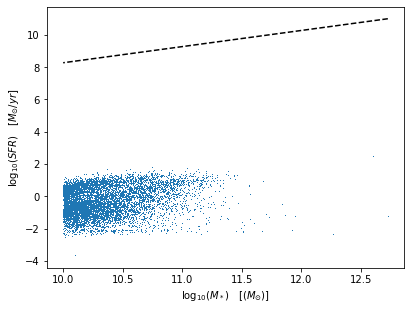

In [30]:
plt.plot(logsm, logsfr, ',')
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
plt.show()



#sf-qu divide
y = logsm - 1.8 + 0.3*0.25
plt.plot(logsm, logsfr, ',')
plt.plot(logsm, y, '--k')
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
plt.show()

## Calculating $\lambda$

$\lambda$ is a measure of the black hole specific accretion rates, it is defined (from Aird and Coil 2021):

$ \lambda=\frac{k_{\mathrm{bol}} L_{\mathrm{X}}}{1.3 \times 10^{38} \mathrm{erg}\, \mathrm{s}^{-1} \times 0.002 \frac{\mathrm{M}_{\mathrm{*}}}{\mathrm{M}_{\odot}}} $
 where $k_{\mathrm{bol}} = 25.0$

Text(0, 0.5, '$\\lambda$')

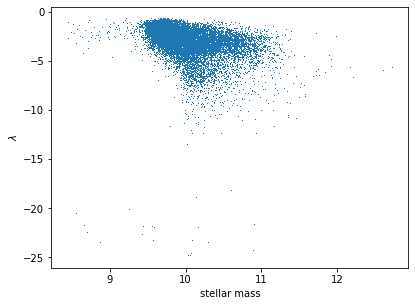

In [31]:
plt.plot(np.log10(r['z137']['sm']), np.log10(r['z137']['lambda']), ',')
plt.xlabel('stellar mass')
plt.ylabel('$\lambda$')

#### Replicating figures 3 and 4 from xatgp iii using $\lambda$s instead 

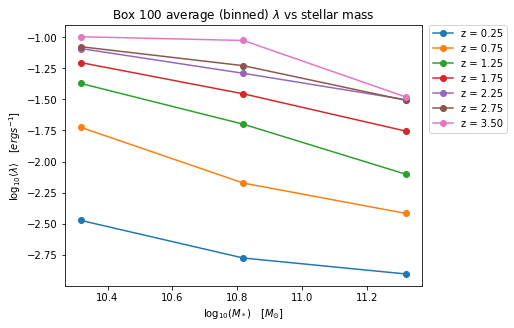

In [32]:
lmbda_av = []

for key in r:
    
    # NEW WAY: binning the mass data
    bins = np.array([10, 10.5, 11, np.inf])
    digitized = np.digitize(np.log10(r[key]['sm']), bins)
    
    # finding avergae lmbda for binned data
    lmbda_avnew = np.array([np.mean(r[key]['lambda'][digitized == i]) for i in range(1, len(bins))])
    lmbda_av.append(lmbda_avnew)
    
    
lmbda_av = np.asarray(lmbda_av)

# midpoint of each mass bin as x values
sm_med = np.array([np.mean([10**10, 10**10.5]), np.mean([10**10.5, 10**11]), np.mean([10**11, 10**11.5])])

plt.plot(np.log10(sm_med), np.log10(lmbda_av[0]), '-o', label='z = 0.25')
plt.plot(np.log10(sm_med), np.log10(lmbda_av[1]), '-o', label='z = 0.75')
plt.plot(np.log10(sm_med), np.log10(lmbda_av[2]), '-o', label='z = 1.25')
plt.plot(np.log10(sm_med), np.log10(lmbda_av[3]), '-o', label='z = 1.75')
plt.plot(np.log10(sm_med), np.log10(lmbda_av[4]), '-o', label='z = 2.25')
plt.plot(np.log10(sm_med), np.log10(lmbda_av[5]), '-o', label='z = 2.75')
plt.plot(np.log10(sm_med), np.log10(lmbda_av[6]), '-o', label='z = 3.50')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
plt.xlabel('$\log_{10}(M_*) \quad [M_{\odot}]$')
plt.ylabel(r'$\log_{10}\langle \lambda \rangle \quad [erg s^{-1}]$')
plt.title('Box 100 average (binned) $\lambda$ vs stellar mass')
plt.show()

/tmp/ipykernel_2157244/2908808670.py:7: RuntimeWarning: divide by zero encountered in log10
  digitized = np.digitize(np.log10(r[key]['SFR']), bins)
/home/sarah/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/sarah/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


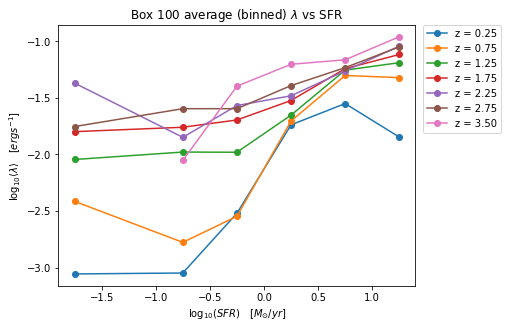

In [33]:
lmbda_av = []

for key in r:
    
    # NEW WAY: binning the mass data
    bins = np.array([-2.5, -1, -0.5, 0, 0.5, 1, np.inf])
    digitized = np.digitize(np.log10(r[key]['SFR']), bins)
    
    # finding avergae lmbda for binned data
    lmbda_avnew = np.array([np.mean(r[key]['lambda'][digitized == i]) for i in range(1, len(bins))])
    lmbda_av.append(lmbda_avnew)
    
    
lmbda_av = np.asarray(lmbda_av)

SFR_bins = np.array([-1.75, -0.75, -0.25, 0.25, 0.75, 1.25])

plt.plot(SFR_bins, np.log10(lmbda_av[0]), '-o', label='z = 0.25')
plt.plot(SFR_bins, np.log10(lmbda_av[1]), '-o', label='z = 0.75')
plt.plot(SFR_bins, np.log10(lmbda_av[2]), '-o', label='z = 1.25')
plt.plot(SFR_bins, np.log10(lmbda_av[3]), '-o', label='z = 1.75')
plt.plot(SFR_bins, np.log10(lmbda_av[4]), '-o', label='z = 2.25')
plt.plot(SFR_bins, np.log10(lmbda_av[5]), '-o', label='z = 2.75')
plt.plot(SFR_bins, np.log10(lmbda_av[6]), '-o', label='z = 3.50')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
plt.xlabel('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
plt.ylabel(r'$\log_{10}\langle \lambda \rangle \quad [erg s^{-1}]$')
plt.title('Box 100 average (binned) $\lambda$ vs SFR')
plt.show()

In [34]:
folder_path = '/disk04/rad/sim/m25n256/s50/Groups/'
filename = 'm25n256_137.hdf5'
obj = caesar.load(os.path.join(folder_path, filename))

Lx = get_ALL_Lx(obj)

AGN_frac = (len(Lx[Lx != 0]))/(len(Lx))

#print(Lx)
print(AGN_frac)

#ind = get_non_zeros(obj)
#stellar_mass = get_stellar_mass(obj, ind)
#SFR = get_SFR(obj, ind)
#sSFR = SFR/stellar_mass

yt : [INFO     ] 2023-01-05 14:02:19,415 Opening /disk04/rad/sim/m25n256/s50/Groups/m25n256_137.hdf5
yt : [INFO     ] 2023-01-05 14:02:19,451 Found 7848 halos
yt : [INFO     ] 2023-01-05 14:02:19,460 Found 841 galaxies


0.36741973840665876


/home/sarah/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_2157244/2086695287.py:37: RuntimeWarning: divide by zero encountered in log10
  Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')


## AGN Fractions

In [35]:
def find_fracs(lambdas):
    '''
    Finds the percentage of galaxies with lambda greater than 0.01 and 0.1 for a given set of galaxies
    defined by their input log lambdas.
    
    Parameters:
                lambdas : array_like
                          An array of log(lambdas)
                      

        Returns:
                frac_gt2 : float
                           The percentage of galaxies with lambda greater than 0.01
                frac_gt1 : float
                           The percentage of galaxies with lambda greater than 0.1
                           
    
    '''
    l_gr2 = lambdas[lambdas > -2]
            
    if len(l_gr2) == 0:
        print('there are no lambdas>0.01')
        frac_gt2 = float('NaN')
    else:
        frac_gt2 = (len(l_gr2)/len(lambdas))*100

    l_gr1 = lambdas[lambdas > -1]

    if len(l_gr1) == 0:
        print('there are no lambdas>0.1')
        frac_gt1 = float('Nan')
    else:
        frac_gt1 = (len(l_gr1)/len(lambdas))*100

    #print(frac_gt2)
    #print(frac_gt1)
    
    return frac_gt2, frac_gt1

In [36]:
def find_fracs(lambdas, Lx):
    '''
    Finds the percentage of galaxies with lambda greater than 0.01 and 0.1 AND Lx greater than 10^42 for a given set 
    of galaxies defined by their input log lambdas.
    
    Parameters:
                lambdas : array_like
                          An array of log(lambdas)
                      

        Returns:
                frac_gt2 : float
                           The percentage of galaxies with lambda greater than 0.01 AND Lx greater than 10^42
                frac_gt1 : float
                           The percentage of galaxies with lambda greater than 0.1 AND Lx greater than 10^42
                           
    
    '''
    mask2 = (lambdas > -2) & (Lx > 1e42)
    l_gr2 = lambdas[mask2]
            
    if len(l_gr2) == 0:
        print('there are no lambdas>0.01')
        frac_gt2 = float('NaN')
    else:
        frac_gt2 = (len(l_gr2)/len(lambdas))*100

    mask1 = (lambdas > -1) & (Lx > 1e42)
    l_gr1 = lambdas[mask1]

    if len(l_gr1) == 0:
        print('there are no lambdas>0.1')
        frac_gt1 = float('Nan')
    else:
        frac_gt1 = (len(l_gr1)/len(lambdas))*100

    #print(frac_gt2)
    #print(frac_gt1)
    
    return frac_gt2, frac_gt1

/tmp/ipykernel_2157244/2384128058.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(all_r['z137']['sm']), np.log10(all_r['z137']['sSFR']), ',')


(10.0, 12.861624677540775)

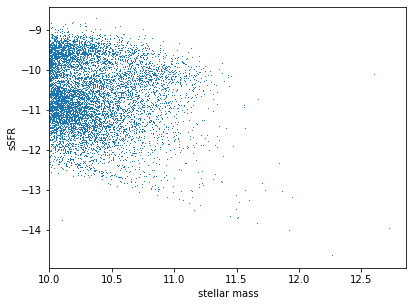

In [37]:
plt.plot(np.log10(all_r['z137']['sm']), np.log10(all_r['z137']['sSFR']), ',')
plt.xlabel('stellar mass')
plt.ylabel('sSFR')
plt.xlim(left=10)

/tmp/ipykernel_2157244/3046353866.py:7: RuntimeWarning: divide by zero encountered in log10
  digitized = np.digitize(np.log10(all_r[key]['sSFR']), bins)
/tmp/ipykernel_2157244/3046353866.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.plot(sSFR_bins, np.log10(AGN_fracs[5]), '-o', label='z = 2.75')


[[0.63102725 0.81075269 0.89115874 0.98159806]
 [0.69379845 0.84921466 0.90222063 0.98398876]
 [0.6416185  0.875      0.94275093 0.97833645]
 [0.5        0.8125     0.93736501 0.98344487]
 [0.5        0.69767442 0.9057971  0.98580841]
 [0.         0.77777778 0.86363636 0.99110032]
 [       nan 0.5        0.88888889 0.98848684]]


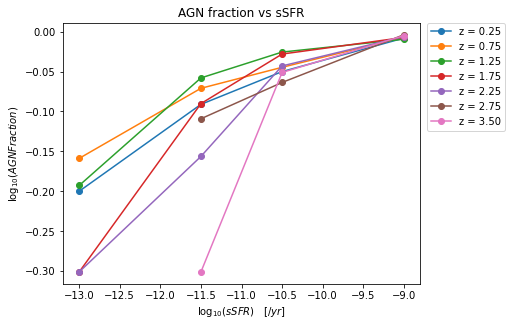

In [38]:
AGN_fracs = []

for key in all_r:
    
    # NEW WAY: binning the mass data
    bins = np.array([-14, -12, -11, -10, -8])
    digitized = np.digitize(np.log10(all_r[key]['sSFR']), bins)
    
    # finding AGN fraction for binned data
    AGN_frac_per_snap = np.array([])
    for i in range(1, len(bins)):
        binned_Lx = (all_r[key]['Lx'][digitized == i])
        if len(binned_Lx) == 0:
            frac = float('NaN')
        else:
            frac = len(binned_Lx[binned_Lx != 0]) / len(binned_Lx)
        AGN_frac_per_snap = np.append(AGN_frac_per_snap, frac)
        
    AGN_fracs.append(AGN_frac_per_snap)
    
AGN_fracs = np.asarray(AGN_fracs)
print(AGN_fracs)

sSFR_bins = np.array([-13, -11.5, -10.5, -9])

plt.plot(sSFR_bins, np.log10(AGN_fracs[0]), '-o', label='z = 0.25')
plt.plot(sSFR_bins, np.log10(AGN_fracs[1]), '-o', label='z = 0.75')
plt.plot(sSFR_bins, np.log10(AGN_fracs[2]), '-o', label='z = 1.25')
plt.plot(sSFR_bins, np.log10(AGN_fracs[3]), '-o', label='z = 1.75')
plt.plot(sSFR_bins, np.log10(AGN_fracs[4]), '-o', label='z = 2.25')
plt.plot(sSFR_bins, np.log10(AGN_fracs[5]), '-o', label='z = 2.75')
plt.plot(sSFR_bins, np.log10(AGN_fracs[6]), '-o', label='z = 3.50')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
plt.xlabel('$\log_{10}(sSFR) \quad [/yr]$')
plt.ylabel('$\log_{10}(AGN Fraction)$')
plt.title('AGN fraction vs sSFR')
plt.show()

#### Finding the probability distribution for lambda

/tmp/ipykernel_2157244/4213832319.py:2: RuntimeWarning: divide by zero encountered in log10
  lambdas = np.log10(all_r['z137']['lambda'])


10181
       lambda      
-------------------
  -5.68532895363291
 -6.081598500371082
                nan
-6.7937195042815945
 -5.681110831646929
                nan
                nan
-2.5901278483565293
                nan
                nan
                ...
 -2.377025920424361
  -2.62891815617348
-2.5276352885173665
 -3.826431554307405
 -9.177595567596136
-3.6606249394197743
-1.4846634781929378
-2.0538150801519124
 -3.604901437732194
-3.2108405930865405
Length = 10181 rows
10181


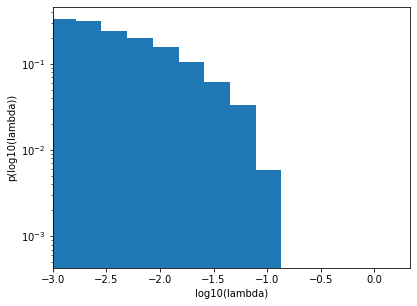

In [39]:
#print(all_r['z137']['lambda'])
lambdas = np.log10(all_r['z137']['lambda'])

print(len(lambdas))
for i in range(len(lambdas)):
    if np.abs(lambdas[i]) == np.inf:
        lambdas[i] = float('NaN')
print(lambdas)    
print(len(lambdas))
plt.hist(lambdas, bins=100,density=True)
plt.xlim(left=-3)
plt.xlabel('log10(lambda)')
plt.ylabel('p(log10(lambda))')
plt.yscale('log')

0.051959532462430014
0.0004911108928396031


Text(0, 0.5, 'p(log10(lambda))')

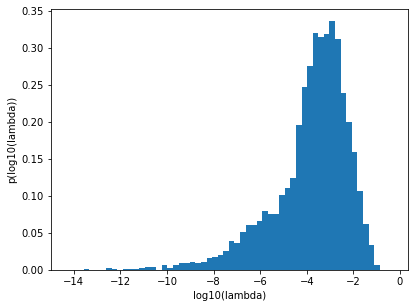

In [40]:
l_gr2 = lambdas[lambdas > -2]
#print(len(l_gr2))
frac_gt2 = len(l_gr2)/len(lambdas)
print(frac_gt2)
l_gr1 = lambdas[lambdas > -1]
#print(len(l_gr1))
frac_gt1 = len(l_gr1)/len(lambdas)
print(frac_gt1)

plt.hist(lambdas, bins=100,density=True)
plt.xlim(left=-15)
plt.xlabel('log10(lambda)')
plt.ylabel('p(log10(lambda))')

In [41]:
all_r = get_all_r()

AGN_fracs_gt2 = []
AGN_fracs_gt1 = []
SFR_bins = []

for count, key in enumerate(all_r):
    print(key)
    AGN_frac_per_bin_gt2 = np.array([])
    AGN_frac_per_bin_gt1 = np.array([])
    
    #extract xray luminosities to make mask Lx> 10^42
    Lx = all_r[key]['Lx']
    
    # NEW WAY: binning the mass data
    SFRs_all = all_r[key]['SFR']
    SFRs = SFRs_all
    logSFRs = np.log10(np.asarray(SFRs[SFRs != 0]))
    sort_logSFR = logSFRs[np.argsort(logSFRs)]
    true_min = sort_logSFR[0]
    print(true_min)
    
    rand_sams = np.zeros(SFRs[SFRs == 0].shape)
    #print(rand_sams)
    for i in range(len(rand_sams)):
        rand_sams[i] = np.random.uniform(1e-5, 1e-4)
        #print(rand_sams[i])

    SFRs[SFRs == 0] = rand_sams
    #print(SFRs)
    
    #SFRs[SFRs == 0] = 0.0001
    logSFRs = np.log10(np.asarray(SFRs))
    sort_logSFR = logSFRs[np.argsort(logSFRs)]
    #print(sort_logSFR)
    print('min: ', true_min, 'max: ', sort_logSFR[-1])

    
    binned_SFR = np.array_split(sort_logSFR, 5)
    #print(binned_SFR)

    SFRs_midpoints = np.array([])
    bins = np.array([])
    
    #if count == 0:
    #    for i in binned_SFR:
    #        bins = np.append(bins, i[0])
    #    bins[1] = true_min
    #    for i in bins:
        #SFRs_midpoints = np.append(SFRs_midpoints, np.median(i))
    
        
    for i in binned_SFR:
        bins = np.append(bins, i[0])
        SFRs_midpoints = np.append(SFRs_midpoints, np.median(i))
    
    print('plot points', SFRs_midpoints)
    bins = np.append(bins, binned_SFR[-1][-1])
    print('bin boundaries', bins)
    
        
    

    SFR_bins.append(SFRs_midpoints)
    
    digitized = np.digitize(np.log10(all_r[key]['SFR']), bins)
    
    for i in range(1, len(bins)):
        print('bin', i)
        lambdas = np.log10(all_r[key]['lambda'][digitized == i])
        Lx_binned = Lx[digitized == i]
        frac_gt2, frac_gt1 = find_fracs(lambdas, Lx_binned)

        AGN_frac_per_bin_gt2 = np.append(AGN_frac_per_bin_gt2, frac_gt2)
        AGN_frac_per_bin_gt1 = np.append(AGN_frac_per_bin_gt1, frac_gt1)

    #print(AGN_frac_per_bin_gt2, AGN_frac_per_bin_gt1)
    
    AGN_fracs_gt2.append(AGN_frac_per_bin_gt2)
    AGN_fracs_gt1.append(AGN_frac_per_bin_gt1)
    
    
print('agn fracs', AGN_fracs_gt2, AGN_fracs_gt1)
#print('sfr bins', SFR_bins)

yt : [INFO     ] 2023-01-05 14:02:21,377 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_137.hdf5
yt : [INFO     ] 2023-01-05 14:02:21,422 Found 482650 halos
yt : [INFO     ] 2023-01-05 14:02:21,433 Found 49752 galaxies
/home/sarah/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_2157244/2979682850.py:49: RuntimeWarning: divide by zero encountered in log10
  Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
yt : [INFO     ] 2023-01-05 14:02:23,645 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_114.hdf5
yt : [INFO     ] 2023-01-05 14:02:23,710 Found 517907 halos
yt : [INFO     ] 2023-01-05 14:02:23,723 Found 41585 galaxies
yt : [INFO     ] 2023-01-05 14:02:26,438 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_097.hdf5
yt : [INFO     ] 2023-01-05 14:02:26,503 Found 539783 h

z137
-3.6864035180465304
min:  -3.6864035180465304 max:  2.458611018268569
plot points [-4.29455211 -1.46451534 -0.73241846  0.01627627  0.72446529]
bin boundaries [-4.99969706 -4.04838441 -1.01903558 -0.41192114  0.41190455  2.45861102]
bin 1
there are no lambdas>0.1
bin 2
there are no lambdas>0.1
bin 3
there are no lambdas>0.1
bin 4
there are no lambdas>0.1
bin 5
z114
-2.5417112233844974
min:  -2.5417112233844974 max:  2.7614892387747902
plot points [-4.07982607 -0.5564235   0.05997539  0.83891599  1.23689065]
bin boundaries [-4.99719652 -0.91533688 -0.30871953  0.57564301  1.02048443  2.76148924]
bin 1
bin 2
there are no lambdas>0.1
bin 3
there are no lambdas>0.1
bin 4
bin 5
z097
-2.3929043418925238
min:  -2.3929043418925238 max:  2.5490332875411035
plot points [-1.02229527  0.20555165  0.96409343  1.25420628  1.58404661]
bin boundaries [-4.97976459 -0.2405439   0.71468213  1.1190859   1.3897841   2.54903329]
bin 1
bin 2
bin 3
bin 4
bin 5
z084
-2.3491226097846645
min:  -2.3491226097

/tmp/ipykernel_2157244/3971687464.py:70: RuntimeWarning: divide by zero encountered in log10
  lambdas = np.log10(all_r[key]['lambda'][digitized == i])


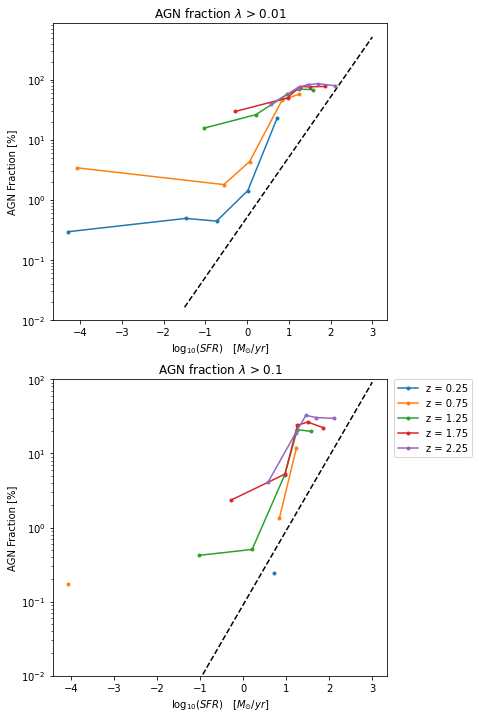

In [42]:
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])

# equations 5 and 6 line
logy2 = -0.59 + SFR_bins_x
y2 = (10**logy2)*2
#print(y2)
logy1 = -1.34 + SFR_bins_x
y1 = (10**logy1)*2
#print(y1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.plot(SFR_bins_x, y2, '--', color='k')
ax1.plot(SFR_bins[0],  AGN_fracs_gt2[0], linestyle='-', marker='.', label='z = 0.25')
ax1.plot(SFR_bins[1],  AGN_fracs_gt2[1], linestyle='-', marker='.', label='z = 0.75')
ax1.plot(SFR_bins[2],  AGN_fracs_gt2[2], linestyle='-', marker='.', label='z = 1.25')
ax1.plot(SFR_bins[3],  AGN_fracs_gt2[3], linestyle='-', marker='.', label='z = 1.75')
ax1.plot(SFR_bins[4],  AGN_fracs_gt2[4], linestyle='-', marker='.', label='z = 2.25')
#ax1.plot(SFR_bins[5],  AGN_fracs_gt2[5], linestyle='-', marker='.', label='z = 2.75')
#ax1.plot(SFR_bins[6],  AGN_fracs_gt2[6], linestyle='-', marker='.', label='z = 3.50')

ax1.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax1.yaxis.set_label_text('AGN Fraction [%]')
ax1.set_title('AGN fraction $\lambda$ > 0.01')
ax1.set_yscale('log')
ax1.set_ylim(bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)

ax2.plot(SFR_bins_x, y1, '--', color='k')
ax2.plot(SFR_bins[0],  AGN_fracs_gt1[0], linestyle='-', marker='.', label='z = 0.25')
ax2.plot(SFR_bins[1],  AGN_fracs_gt1[1], linestyle='-', marker='.', label='z = 0.75')
ax2.plot(SFR_bins[2],  AGN_fracs_gt1[2], linestyle='-', marker='.', label='z = 1.25')
ax2.plot(SFR_bins[3],  AGN_fracs_gt1[3], linestyle='-', marker='.', label='z = 1.75')
ax2.plot(SFR_bins[4],  AGN_fracs_gt1[4], linestyle='-', marker='.', label='z = 2.25')
#ax2.plot(SFR_bins[5],  AGN_fracs_gt1[5], linestyle='-', marker='.', label='z = 2.75')
#ax2.plot(SFR_bins[6],  AGN_fracs_gt1[6], linestyle='-', marker='.', label='z = 3.50')

ax2.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax2.yaxis.set_label_text('AGN Fraction [%]')
ax2.set_title('AGN fraction $\lambda$ > 0.1')
ax2.set_yscale('log')
ax2.set_ylim(bottom=10**(-2), top=10**2)
#ax2.set_xlim(left=-2, right=1.5)

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()

In [43]:
#testing random sampling
sfr = np.zeros(10)
sfr[3], sfr[1], sfr[9] = 3, 4, 5
print(sfr)
rand_sams = np.zeros(sfr[sfr==0].shape)
print(rand_sams)
for i in range(len(rand_sams)):
    rand_sams[i] = np.random.uniform(1e-5, 1e-4)
    print(rand_sams[i])

sfr[sfr==0] = rand_sams
print(sfr)

[0. 4. 0. 3. 0. 0. 0. 0. 0. 5.]
[0. 0. 0. 0. 0. 0. 0.]
5.938516310616923e-05
2.0006765933558732e-05
9.620431426620745e-05
4.186841233602129e-05
3.392506470637333e-05
5.378029026181914e-05
6.247902138234938e-05
[5.93851631e-05 4.00000000e+00 2.00067659e-05 3.00000000e+00
 9.62043143e-05 4.18684123e-05 3.39250647e-05 5.37802903e-05
 6.24790214e-05 5.00000000e+00]


## Replicating the sSFR histogram for sf and qu galaxies (figure 4 in simba 2019)

In [44]:
all_r = get_all_r()

yt : [INFO     ] 2023-01-05 14:02:40,794 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_137.hdf5
yt : [INFO     ] 2023-01-05 14:02:40,866 Found 482650 halos
yt : [INFO     ] 2023-01-05 14:02:40,882 Found 49752 galaxies
/home/sarah/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_2157244/2979682850.py:49: RuntimeWarning: divide by zero encountered in log10
  Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
yt : [INFO     ] 2023-01-05 14:02:48,495 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_114.hdf5
yt : [INFO     ] 2023-01-05 14:02:48,534 Found 517907 halos
yt : [INFO     ] 2023-01-05 14:02:48,545 Found 41585 galaxies
yt : [INFO     ] 2023-01-05 14:02:51,391 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_097.hdf5
yt : [INFO     ] 2023-01-05 14:02:51,426 Found 539783 h

In [45]:
ssfrs10 = []
ssfrs11 = []
ssfrs = []
sms = []
for key in all_r:  
    # creating the masks to bin the stellar masses
    # there should be no galaxies greater than 10^11.5 so the upper most bin is just > 10^11
    sm = all_r[key]['sm']
    m10_10 = (sm > (1e10))
    m11 = (sm > 1e11)
    

    ssfr = all_r[key]['sSFR']
    ssfr10 = ssfr[m10_10]
    logssfr10 = np.log10(np.array(ssfr10[ssfr10 != 0].data)) + 9
    ssfrs10.append(logssfr10)
    
    ssfr11 = ssfr[m11]
    logssfr11 = np.log10(np.array(ssfr11[ssfr11 != 0].data)) + 9
    ssfrs11.append(logssfr11)
    
    logssfr = np.log10(np.array(ssfr[ssfr != 0].data)) + 9
    ssfrs.append(logssfr)
    
    logsm = np.log10(np.array(sm[ssfr != 0].data))
    sms.append(logsm)

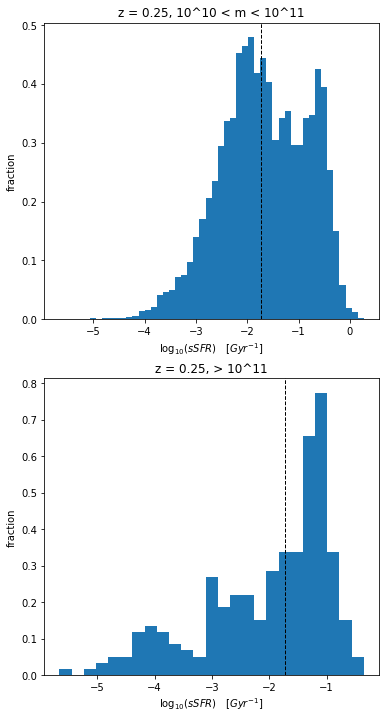

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.hist(ssfrs10[0], bins=50,density=True)
ax1.axvline((-1.8 + 0.3*0.25), color='k', linestyle='dashed', linewidth=1)
ax1.xaxis.set_label_text('$\log_{10}(sSFR) \quad [Gyr^{-1}]$')
ax1.yaxis.set_label_text('fraction')
ax1.set_title('z = 0.25, 10^10 < m < 10^11')

ax2.hist(ssfrs11[0], bins=25,density=True)
ax2.axvline((-1.8 + 0.3*0.25), color='k', linestyle='dashed', linewidth=1)
ax2.xaxis.set_label_text('$\log_{10}(sSFR) \quad [Gyr^{-1}]$')
ax2.yaxis.set_label_text('fraction')
ax2.set_title('z = 0.25, > 10^11')

plt.show()

/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '$\\log_{10}(sSFR) \\quad [yr^{-1}]$')

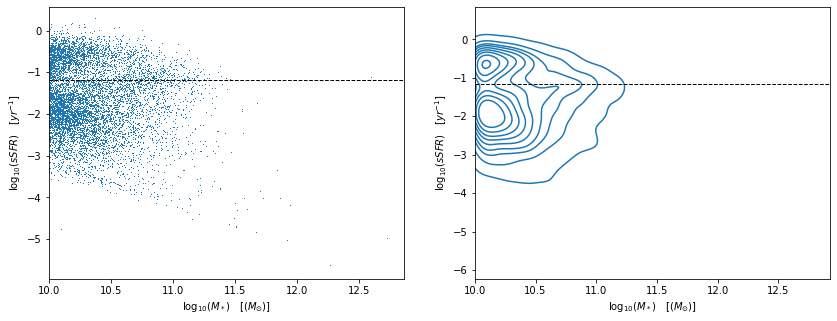

In [47]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.plot(sms[0], ssfrs[0],  ',')
ax1.axhline((-1.25 + 0.3*0.25), color='k', linestyle='dashed', linewidth=1)
ax1.set_xlim(left=10)
ax1.set_xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
ax1.set_ylabel('$\log_{10}(sSFR) \quad [yr^{-1}]$')

sns.kdeplot(sms[0], ssfrs[0], ax=ax2)
ax2.axhline((-1.25 + 0.3*0.25), color='k', linestyle='dashed', linewidth=1)
ax2.set_xlim(left=10)
ax2.set_xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
ax2.set_ylabel('$\log_{10}(sSFR) \quad [yr^{-1}]$')

In [48]:
sfr = all_r['z137']['SFR']
logsfr = np.log10(sfr[sfr != 0])

sm = all_r['z137']['sm'][sfr != 0]
logsm = np.log10(sm)

Lx = all_r['z137']['Lx'][sfr != 0]
#print(Lx)
for i in range(len(Lx)):
    if Lx[i] == 0:
        Lx[i] = 1e-1
        
logLx = np.log10(Lx)

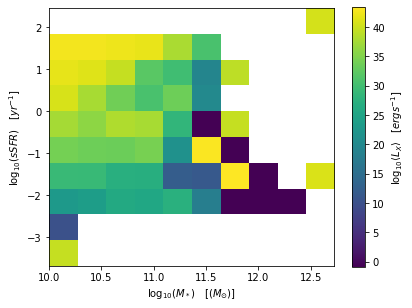

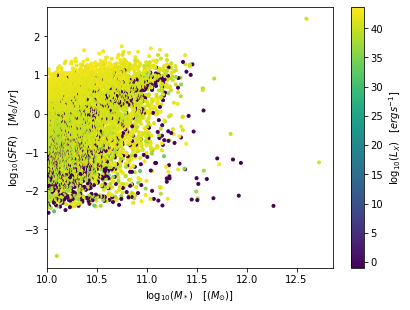

In [49]:
from scipy.stats import binned_statistic_2d

cmap = plt.cm.get_cmap('viridis',1000)
ret = binned_statistic_2d(logsm, logsfr, logLx, statistic=np.mean, bins=10)

plt.imshow(ret.statistic.T, origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.4) 
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(sSFR) \quad [yr^{-1}]$')
plt.colorbar(label=r'$\log_{10}\langle L_{X} \rangle \quad [erg s^{-1}]$')
plt.show()

plt.scatter(logsm, logsfr, c=logLx, marker='.')
plt.xlim(left=10)
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
plt.colorbar(label=r'$\log_{10}( L_{X}) \quad [erg s^{-1}]$')
plt.show()

In [50]:
z = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.5]
logSFRms = []
for i in range(len(sms)):
    logSFRms.append(-7.6 + 0.76*sms[i] + np.log10(1+z[i]))
    
stellarmasses = np.concatenate(sms)
logSFRms = np.concatenate(logSFRms)

/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


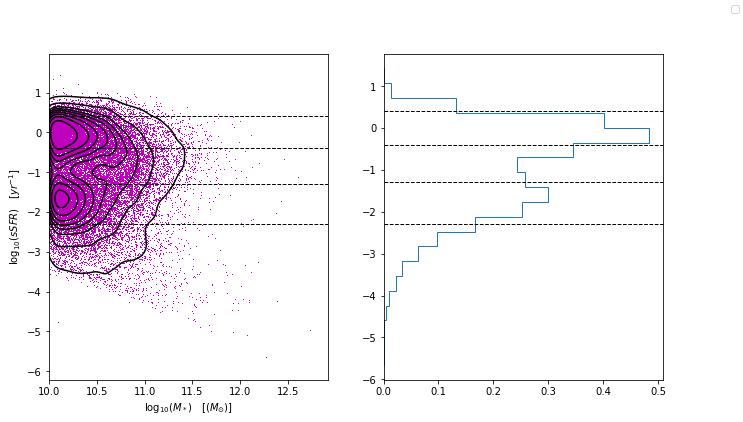

In [51]:
SFRs = np.concatenate(ssfrs)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,6))

ax1.plot(stellarmasses, SFRs,  'm,')
sns.kdeplot(stellarmasses, SFRs, color='k', ax = ax1, linewidth=0.1)
ax1.set_xlim(left=10)
ax1.axhline((0.4), color='k', linestyle='dashed', linewidth=1)
ax1.axhline((-0.4), color='k', linestyle='dashed', linewidth=1)
ax1.axhline((-1.3), color='k', linestyle='dashed', linewidth=1)
ax1.axhline((-2.3), color='k', linestyle='dashed', linewidth=1)
#ax1.axhline((-1.25 + 0.3*0.25), color='r', linestyle='dashed', linewidth=1)
ax1.set_xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
ax1.set_ylabel('$\log_{10}(sSFR) \quad [yr^{-1}]$')


ax2.hist(SFRs, bins=20, orientation='horizontal', histtype='step', density=True)
ax2.axhline((0.4), color='k', linestyle='dashed', linewidth=1)
ax2.axhline((-0.4), color='k', linestyle='dashed', linewidth=1)
ax2.axhline((-1.3), color='k', linestyle='dashed', linewidth=1)
ax2.axhline((-2.3), color='k', linestyle='dashed', linewidth=1)
#ax2.axhline((-1.25 + 0.3*0.25), color='r', linestyle='dashed', linewidth=1, label='sf-qu cut-off')
fig.legend()

In [52]:
z = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.5]

logSFR_MS_list = []
logsm_list = []
loglambda_list = []
logLx_list = []

for i, key in enumerate(all_r):  
    # creating the masks to bin the stellar masses
    # there should be no galaxies greater than 10^11.5 so the upper most bin is just > 10^11
    sm = all_r[key]['sm']

    SFR = all_r[key]['SFR']
    
    lmbda = all_r[key]['lambda']
    
    Lx = all_r[key]['Lx']
    
    logSFR = np.log10(SFR[SFR != 0].data)

    logsm = np.log10(sm[SFR != 0].data)
    
    loglambda = np.log10(lmbda[SFR != 0].data)
    
    logLx = np.log10(Lx[SFR != 0].data)
    
    logSFR_MS = logSFR + 7.6 - 0.76*logsm - 2.95*np.log10(1+z[i])
    
    logSFR_MS_list.append(logSFR_MS)
    logsm_list.append(logsm)
    loglambda_list.append(loglambda)
    logLx_list.append(logLx)

/tmp/ipykernel_2157244/999684150.py:23: RuntimeWarning: divide by zero encountered in log10
  loglambda = np.log10(lmbda[SFR != 0].data)
/tmp/ipykernel_2157244/999684150.py:25: RuntimeWarning: divide by zero encountered in log10
  logLx = np.log10(Lx[SFR != 0].data)


In [53]:
logsm_all = np.concatenate(logsm_list)
logSFR_MS_list = np.concatenate(logSFR_MS_list)
loglambda_list = np.concatenate(loglambda_list)
logLx_list = np.concatenate(logLx_list)

/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


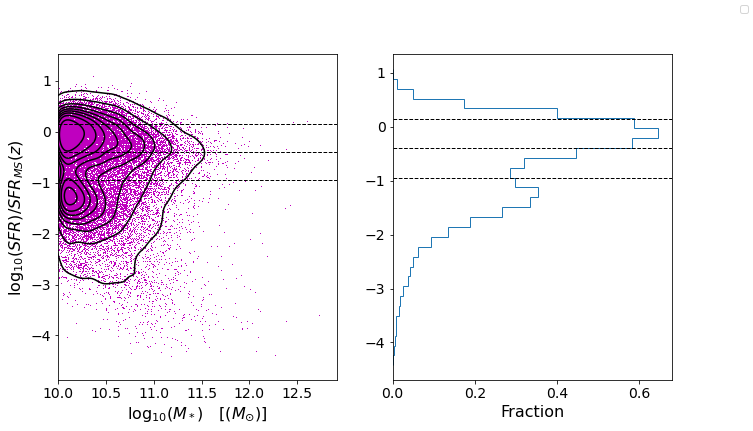

In [54]:


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,6))

ax1.plot(logsm_all, logSFR_MS_list,  'm,')
sns.kdeplot(logsm_all, logSFR_MS_list, color='k', ax = ax1, linewidth=0.1)
ax1.set_xlim(left=10)
ax1.axhline((0.15), color='k', linestyle='dashed', linewidth=1)
ax1.axhline((-0.4), color='k', linestyle='dashed', linewidth=1)
ax1.axhline((-0.95), color='k', linestyle='dashed', linewidth=1)
#ax1.axhline((-2.3), color='k', linestyle='dashed', linewidth=1)
#ax1.axhline((-1.25 + 0.3*0.25), color='r', linestyle='dashed', linewidth=1)
ax1.set_xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$', fontsize=16)
ax1.set_ylabel('$\log_{10}(SFR)/SFR_{MS}(z)$' , fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)


ax2.hist(logSFR_MS_list, bins=30, orientation='horizontal', histtype='step', density=True)
ax2.axhline((0.15), color='k', linestyle='dashed', linewidth=1)
ax2.axhline((-0.4), color='k', linestyle='dashed', linewidth=1)
ax2.axhline((-0.95), color='k', linestyle='dashed', linewidth=1)
#ax2.axhline((-2.3), color='k', linestyle='dashed', linewidth=1)
ax2.set_xlabel('Fraction' , fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
#ax2.axhline((-1.25 + 0.3*0.25), color='r', linestyle='dashed', linewidth=1, label='sf-qu cut-off')
fig.legend()

## ^^ Figure 2


/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


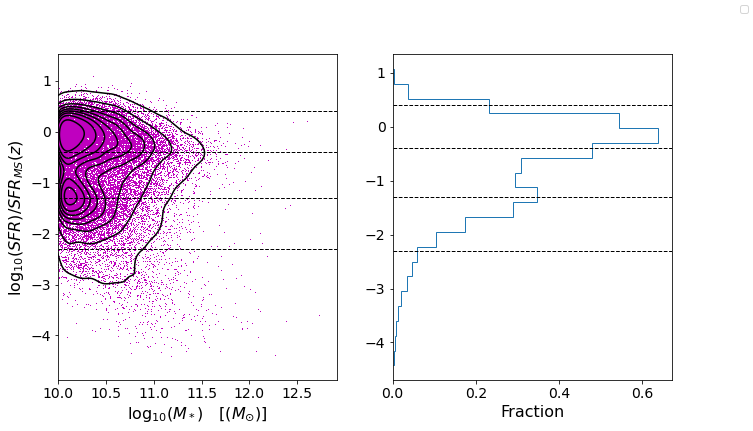

In [55]:


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,6))

ax1.plot(logsm_all, logSFR_MS_list,  'm,')
sns.kdeplot(logsm_all, logSFR_MS_list, color='k', ax = ax1, linewidth=0.1)
ax1.set_xlim(left=10)
ax1.axhline((0.4), color='k', linestyle='dashed', linewidth=1)
ax1.axhline((-0.4), color='k', linestyle='dashed', linewidth=1)
ax1.axhline((-1.3), color='k', linestyle='dashed', linewidth=1)
ax1.axhline((-2.3), color='k', linestyle='dashed', linewidth=1)
#ax1.axhline((-1.25 + 0.3*0.25), color='r', linestyle='dashed', linewidth=1)
ax1.set_xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$', fontsize=16)
ax1.set_ylabel('$\log_{10}(SFR)/SFR_{MS}(z)$' , fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)


ax2.hist(logSFR_MS_list, bins=20, orientation='horizontal', histtype='step', density=True)
ax2.axhline((0.4), color='k', linestyle='dashed', linewidth=1)
ax2.axhline((-0.4), color='k', linestyle='dashed', linewidth=1)
ax2.axhline((-1.3), color='k', linestyle='dashed', linewidth=1)
ax2.axhline((-2.3), color='k', linestyle='dashed', linewidth=1)
ax2.set_xlabel('Fraction' , fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
#ax2.axhline((-1.25 + 0.3*0.25), color='r', linestyle='dashed', linewidth=1, label='sf-qu cut-off')
fig.legend()

# Pixel AGN Fraction Plots

### AGN fraction = no. AGN above threshold in pixel / total no. AGN in pixel

In [56]:
sfr = all_r['z137']['SFR']
logsfr = np.log10(sfr[sfr != 0])

sm = all_r['z137']['sm'][sfr != 0]
logsm = np.log10(sm)

lmbda = all_r['z137']['lambda'][sfr != 0]

for i in range(len(lmbda)):
    if lmbda[i] == 0:
        lmbda[i] = 1e-4

loglmbda = np.log10(lmbda)

Lx = all_r['z137']['Lx'][sfr != 0]

for i in range(len(Lx)):
    if Lx[i] == 0:
        Lx[i] = 1e-1
        
logLx = np.log10(Lx)

In [57]:
def find_fracs2(lambdas, Lx):
    '''
    Finds the percentage of galaxies with lambda greater than 0.01 and 0.1 AND Lx greater than 10^42 for a given set 
    of galaxies defined by their input log lambdas.
    
    Parameters:
                lambdas : array_like
                          An array of log(lambdas)
                      

        Returns:
                frac_gt2 : float
                           The percentage of galaxies with lambda greater than 0.01 AND Lx greater than 10^42
                frac_gt1 : float
                           The percentage of galaxies with lambda greater than 0.1 AND Lx greater than 10^42
                           
    
    '''
    mask2 = (lambdas > -2)
    l_gr2 = lambdas[mask2]
            
    if len(l_gr2) == 0:
        #print('there are no lambdas>0.01')
        frac_gt2 = float('NaN')
    else:
        frac_gt2 = (len(l_gr2)/len(lambdas))*100
        #print('there are lambdas>0.01')

    mask1 = (lambdas > -1)
    l_gr1 = lambdas[mask1]

    if len(l_gr1) == 0:
        #print('there are no lambdas>0.1')
        frac_gt1 = float('Nan')
    else:
        frac_gt1 = (len(l_gr1)/len(lambdas))*100
        #print('there are lambdas>0.1')

    #print(frac_gt2)
    #print(frac_gt1)
    
    return frac_gt2, frac_gt1

In [58]:
def get_binned_fracs(y):
    logsfr_arr = np.asarray(logsfr)
    index = np.where(np.in1d(logsfr_arr, y))[0]
    #print(loglmbda[index])
    print(logLx[index])
    frac_gt2, frac_gt1 = find_fracs2(loglmbda[index], logLx[index])
    return frac_gt2

 Lx
---
        Lx        
------------------
39.669501491061595
        Lx       
-----------------
             -1.0
31.90516570937058
             -1.0
        Lx        
------------------
              -1.0
38.292653151317666
 41.77960918162904
              -1.0
37.613424246706735
              -1.0
              -1.0
42.263886564462354
              -1.0
41.385394744695965
               ...
  35.5563980770275
              -1.0
 39.55681632578173
 40.62909822823304
  39.8644129907515
              -1.0
 36.72098795073408
 37.09789706606084
36.745031067806764
34.839582680973685
Length = 163 rows
        Lx        
------------------
              -1.0
              -1.0
40.174851976586936
 40.44276747466099
              -1.0
              -1.0
 41.28271700404382
              -1.0
 41.08983151138481
37.036512576900456
               ...
 39.08219571378422
37.975668316551655
 40.01780974948012
              -1.0
 40.33952066780531
37.415439752795116
38.550929260086036
 39.805301

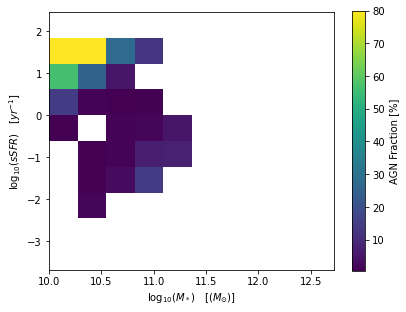

In [59]:
##AGN fractions instead of Lx

cmap = plt.cm.get_cmap('viridis',1000)
ret = binned_statistic_2d(logsm, logsfr, logsfr, statistic=get_binned_fracs, bins=10)

plt.imshow(ret.statistic.T, origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.4) 
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(sSFR) \quad [yr^{-1}]$')
plt.colorbar(label='AGN Fraction [%]')
plt.show()


In [60]:
def find_fracs3(lambdas, Lx, threshold):
    '''
    Finds the percentage of galaxies with lambda greater than 0.01 and 0.1 AND Lx greater than 10^42 for a given set 
    of galaxies defined by their input log lambdas.
    
    Parameters:
                lambdas : array_like
                          An array of log(lambdas)
                     Lx : array_like
                          An array of log(Lx)
              threshold : integer
                          The threshold that log(Lx) is being tested against eg. (38, 39, 40 etc.)
                      

        Returns:
                frac_gt2 : float
                           The percentage of galaxies with lambda greater than 0.01 AND Lx greater than 10^42
                frac_gt1 : float
                           The percentage of galaxies with lambda greater than 0.1 AND Lx greater than 10^42
                           
    
    '''
    mask2 = (lambdas > -2) & (Lx > threshold)
    l_gr2 = lambdas[mask2]
            
    if len(l_gr2) == 0:
        #print('there are no lambdas>0.01')
        frac_gt2 = float('NaN')
    else:
        frac_gt2 = (len(l_gr2)/len(lambdas))*100

    mask1 = (lambdas > -1) & (Lx > threshold)
    l_gr1 = lambdas[mask1]

    if len(l_gr1) == 0:
        #print('there are no lambdas>0.1')
        frac_gt1 = float('Nan')
    else:
        frac_gt1 = (len(l_gr1)/len(lambdas))*100

    return frac_gt2, frac_gt1

### AGN fraction = no. AGN above threshold in each pixel / no. galaxies in each pixel

can I and should I normalise the colorbar so that its 0 - 100 ??

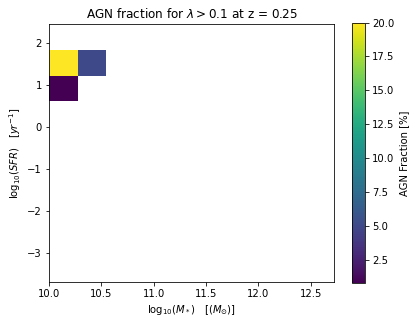

In [61]:
# Testing different Lx thresholds

def get_binned_fracs(y):
    logsfr_arr = np.asarray(logsfr)
    index = np.where(np.in1d(logsfr_arr, y))[0]
    frac_gt2, frac_gt1 = find_fracs3(loglmbda[index], logLx[index], 42)
    return frac_gt1

cmap = plt.cm.get_cmap('viridis',1000)
ret = binned_statistic_2d(logsm, logsfr, logsfr, statistic=get_binned_fracs, bins=10)

plt.imshow(ret.statistic.T, origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.4) 
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(SFR) \quad [yr^{-1}]$')
plt.title('AGN fraction for $\lambda > 0.1$ at z = 0.25')
plt.colorbar(label='AGN Fraction [%]')
plt.show()

yellow pixels are starburst regions, they are strongly correlated with SFR because they are regions of exceptionally high star formation rate
<br> does this mean that starburst regions have higher AGN accretion rates?
<br> this agrees with Aird 2019 (III) figure 9: "In Starburst galaxies, p(λsBHAR) appears shifted toward higher λsBHAR, generally indicating a higher probability of such galaxies hosting an AGN, although the turnover at lower λsBHAR may be stronger than in Main Sequence galaxies (especially at z≳2)"
<br> im not sure what this means though? "However, these measurements tend to lie close to the overall trends given by Equations 6 and 7 (dot-dashed and long-dashed blacklines), indicating that the enhancement of high-λsBHAR AGN may be due to the higher SFRs of the Starburst galaxies."
"These results are consistent with the findings of Bernhard et al. (2016), who found an association between the highest λsBHAR AGN and starburst-level SFRs, and Rodighiero et al. (2015) who find that the average specific accretion rates (measured via stacking) are higher in starburst galaxy samples."


<br> why do only low mass galaxies have more 'high accretion' (alternatively $\lambda$ > threshold) AGN?
<br> this is only z = 0.25, I should look at them all.

### Pixel plots for all other redshifts


In [62]:
sfr = all_r['z114']['SFR']
logsfr = np.log10(sfr[sfr != 0])

sm = all_r['z114']['sm'][sfr != 0]
logsm = np.log10(sm)

lmbda = all_r['z114']['lambda'][sfr != 0]

for i in range(len(lmbda)):
    if lmbda[i] == 0:
        lmbda[i] = 1e-4

loglmbda = np.log10(lmbda)

Lx = all_r['z114']['Lx'][sfr != 0]

for i in range(len(Lx)):
    if Lx[i] == 0:
        Lx[i] = 1e-1
        
logLx = np.log10(Lx)

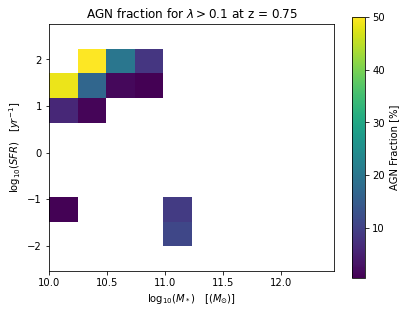

In [63]:
def get_binned_fracs(y):
    logsfr_arr = np.asarray(logsfr)
    index = np.where(np.in1d(logsfr_arr, y))[0]
    frac_gt2, frac_gt1 = find_fracs3(loglmbda[index], logLx[index], 42)
    return frac_gt1

cmap = plt.cm.get_cmap('viridis',1000)
ret = binned_statistic_2d(logsm, logsfr, logsfr, statistic=get_binned_fracs, bins=10)

plt.imshow(ret.statistic.T, origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.4) 
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(SFR) \quad [yr^{-1}]$')
plt.title('AGN fraction for $\lambda > 0.1$ at z = 0.75')
plt.colorbar(label='AGN Fraction [%]')
plt.show()

### AGN fraction = no. AGN above threshold in each pixel / total no. galaxies <- WRONG


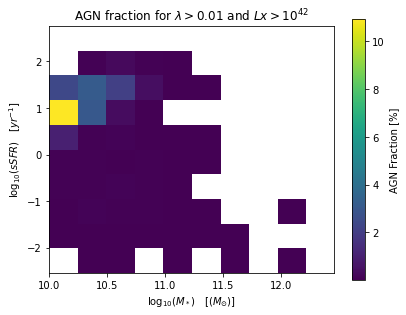

In [64]:
# finding total no. AGN


def find_no_AGN(lambdas, Lx, threshold):
    mask2 = (lambdas > -2) & (Lx > threshold)
    l_gr2 = lambdas[mask2]

    #if len(l_gr2) == 0:
    #    print('there are no lambdas>0.01')


    mask1 = (lambdas > -1) & (Lx > threshold)
    l_gr1 = lambdas[mask1]
    
    #if len(l_gr1) == 0:
    #    print('there are no lambdas>0.1')
        
    return len(l_gr2), len(l_gr1)




def find_nAGN_frac(lambdas, Lx, threshold):
    
    #tot_nAGN_gt2, tot_nAGN_gt1 = find_no_AGN(loglmbda, logLx, threshold)
    tot_nAGN = len(loglmbda)
    
    n_AGN_gt2, n_AGN_gt1 = find_no_AGN(lambdas, Lx, threshold)
            
    if n_AGN_gt2 == 0:
        frac_gt2 = float('NaN')
        #print('there are no lambdas>0.01')
    else:
        #frac_gt2 = (n_AGN_gt2/tot_nAGN_gt2)*100
        frac_gt2 = (n_AGN_gt2/tot_nAGN)*100

    if n_AGN_gt1 == 0:
        #print('there are no lambdas>0.1')
        frac_gt1 = float('Nan')
    else:
        #frac_gt1 = (n_AGN_gt1/tot_nAGN_gt1)*100
        frac_gt1 = (n_AGN_gt1/tot_nAGN)*100
    
    return frac_gt2, frac_gt1

def get_binned_fracs(y):
    logsfr_arr = np.asarray(logsfr)
    index = np.where(np.in1d(logsfr_arr, y))[0]
    frac_gt2, frac_gt1 = find_nAGN_frac(loglmbda[index], logLx[index], 42)
    return frac_gt2

cmap = plt.cm.get_cmap('viridis',1000)
ret = binned_statistic_2d(logsm, logsfr, logsfr, statistic=get_binned_fracs, bins=10)

plt.imshow(ret.statistic.T, origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.4) 
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(sSFR) \quad [yr^{-1}]$')
plt.title('AGN fraction for $\lambda > 0.01$ and $ Lx > 10^{42}$')
plt.colorbar(label='AGN Fraction [%]')
plt.show()

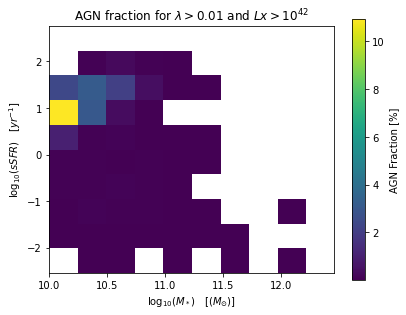

In [65]:
cmap = plt.cm.get_cmap('viridis',1000)
ret = binned_statistic_2d(logsm, logsfr, logsfr, statistic=get_binned_fracs, bins=10)

plt.imshow(ret.statistic.T, origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.4) 
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(sSFR) \quad [yr^{-1}]$')
plt.title('AGN fraction for $\lambda > 0.01$ and $ Lx > 10^{42}$')
plt.colorbar(label='AGN Fraction [%]')
plt.show()

# Plotting the variations in $\lambda$ - a measure of scatter

this is the fraction of AGN with $\lambda$ > 0.1 (rarer) that are also > 0.01 (common)
 <br>  $\lambda$ is a measure of accretion rate so this is variations in rates
 <br> lower fraction = higher variability

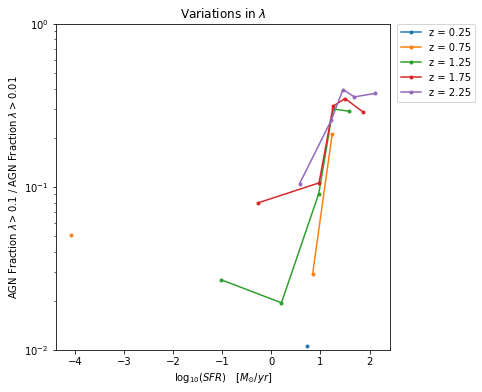

In [66]:
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])

# equations 5 and 6 line
#logy2 = -0.59 + SFR_bins_x
#y2 = (10**logy2)*2
#print(y2)
#logy1 = -1.34 + SFR_bins_x
#y1 = (10**logy1)*2
#print(y1)

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

#ax1.plot(SFR_bins_x, y2, '--', color='k')
ax1.plot(SFR_bins[0],  AGN_fracs_gt1[0]/AGN_fracs_gt2[0], linestyle='-', marker='.', label='z = 0.25')
ax1.plot(SFR_bins[1],  AGN_fracs_gt1[1]/AGN_fracs_gt2[1], linestyle='-', marker='.', label='z = 0.75')
ax1.plot(SFR_bins[2],  AGN_fracs_gt1[2]/AGN_fracs_gt2[2], linestyle='-', marker='.', label='z = 1.25')
ax1.plot(SFR_bins[3],  AGN_fracs_gt1[3]/AGN_fracs_gt2[3], linestyle='-', marker='.', label='z = 1.75')
ax1.plot(SFR_bins[4],  AGN_fracs_gt1[4]/AGN_fracs_gt2[4], linestyle='-', marker='.', label='z = 2.25')
#ax1.plot(SFR_bins[5],  AGN_fracs_gt2[5], linestyle='-', marker='.', label='z = 2.75')
#ax1.plot(SFR_bins[6],  AGN_fracs_gt2[6], linestyle='-', marker='.', label='z = 3.50')

ax1.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax1.yaxis.set_label_text('AGN Fraction $\lambda > 0.1$ / AGN Fraction $\lambda > 0.01$')
ax1.set_title('Variations in $\lambda$')
ax1.set_yscale('log')
ax1.set_ylim(top=10**0, bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)



plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()

this suggests that from the leveling off, the 'normal' ratio of $\lambda$ > 0.1 to $\lambda$ > 0.01 is approx 0.3
<br> and that from the large drops, that lower star formation rate has higher variability in accretion rates

### Redo of AGN fracs plot with bins from fig 2

In [67]:
all_r = get_all_r()

# lists to store the 6 agn fractions (each redshift)
AGN_fracs_gt2 = []
AGN_fracs_gt1 = []

# list to store the 6 sfr bin midpoints for plotting
SFR_bins = []

#iterating across each redshift
for count, key in enumerate(all_r):
    print(key)
    
    #
    AGN_frac_per_bin_gt2 = np.array([])
    AGN_frac_per_bin_gt1 = np.array([])
    
    #extract xray luminosities to make mask Lx> 10^42
    Lx = all_r[key]['Lx']
    
    
    # NEW WAY: binning the mass data
    #extracting the sfrs for this redshift
    SFRs_all = all_r[key]['SFR']
    SFRs = SFRs_all
    
    #finding the minimum sfr value:
    #logging the non-zero sfrs and putting into an array
    logSFRs = np.log10(np.asarray(SFRs[SFRs != 0]))
    
    #sorting the sfrs so they go from low to high
    sort_logSFR = logSFRs[np.argsort(logSFRs)]
    
    #finding the minimum value of sfr
    true_min = sort_logSFR[0]
    print(true_min)
    
    
    #creating an empty array with the size equal to the amount of 0 sfr values
    rand_sams = np.zeros(SFRs[SFRs == 0].shape)
        #print(rand_sams)
    
    #filling the empty array with random numbers ranging between 0.000001 and 0.00001
    for i in range(len(rand_sams)):
        rand_sams[i] = np.random.uniform(1e-5, 1e-4)
        #print(rand_sams[i])

        
    #replacing 0 sfr values with the randomly sampled low values
    SFRs[SFRs == 0] = rand_sams
        #print(SFRs)
    
    #logging the full sfr array with 0 values replaced
    logSFRs = np.log10(np.asarray(SFRs))
    
    #sorting the sfrs into ascending order
    sort_logSFR = logSFRs[np.argsort(logSFRs)]
        #print(sort_logSFR)
    #book-keeping the sfr ranges
    print('min: ', true_min, 'max: ', sort_logSFR[-1])

    #binning the sorted sfrs into 5 equal sized bins
    binned_SFR = np.array_split(sort_logSFR, 5)
    #print(binned_SFR)

    #empty arrays for the sfr midpoints and the bin boundaries
    SFRs_midpoints = np.array([])
    bins = np.array([])
    
    #iterating across each bin
    for i in binned_SFR:
        #adding the lower boundary of each bin into the boundary array
        bins = np.append(bins, i[0])
        #adding the sfr median into the midpoints array for plotting
        SFRs_midpoints = np.append(SFRs_midpoints, np.median(i))
    
    print('plot points', SFRs_midpoints)
    # adding the final boundary which is the last value in the last bin
    bins = np.append(bins, binned_SFR[-1][-1])
    print('bin boundaries', bins)
    
        
    
    #adding the specific redshifts sfr plotting points to the sfr plotting points array
    SFR_bins.append(SFRs_midpoints)
    
    # binning the unsorted sfr data based on the bin boundaries
    digitized = np.digitize(np.log10(all_r[key]['SFR']), bins)
    
    # iterating across each bin
    for i in range(1, len(bins)):
        print('bin', i)
        # finding the lambdas in a certain bin
        lambdas = np.log10(all_r[key]['lambda'][digitized == i])
        # finding the Lxs in a certain bin
        Lx_binned = Lx[digitized == i]
        # finding the agn fractions (2) for a certain bin
        frac_gt2, frac_gt1 = find_fracs(lambdas, Lx_binned)

        #adding the agn fraction of each bin to an array length 5 (no of bins)
        AGN_frac_per_bin_gt2 = np.append(AGN_frac_per_bin_gt2, frac_gt2)
        AGN_frac_per_bin_gt1 = np.append(AGN_frac_per_bin_gt1, frac_gt1)

    #print(AGN_frac_per_bin_gt2, AGN_frac_per_bin_gt1)
    
    # adding the certain redshifts agn fraction for each bin, into an array length 6 (no of redshifts)
    AGN_fracs_gt2.append(AGN_frac_per_bin_gt2)
    AGN_fracs_gt1.append(AGN_frac_per_bin_gt1)
    
    
print('agn fracs', AGN_fracs_gt2, AGN_fracs_gt1)
#print('sfr bins', SFR_bins)

yt : [INFO     ] 2023-01-05 14:04:55,734 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_137.hdf5
yt : [INFO     ] 2023-01-05 14:04:55,766 Found 482650 halos
yt : [INFO     ] 2023-01-05 14:04:55,776 Found 49752 galaxies
/home/sarah/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_2157244/2979682850.py:49: RuntimeWarning: divide by zero encountered in log10
  Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
yt : [INFO     ] 2023-01-05 14:04:59,210 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_114.hdf5
yt : [INFO     ] 2023-01-05 14:04:59,273 Found 517907 halos
yt : [INFO     ] 2023-01-05 14:04:59,289 Found 41585 galaxies
yt : [INFO     ] 2023-01-05 14:05:01,472 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_097.hdf5
yt : [INFO     ] 2023-01-05 14:05:01,508 Found 539783 h

z137
-3.6864035180465304
min:  -3.6864035180465304 max:  2.458611018268569
plot points [-4.30989665 -1.46451534 -0.73241846  0.01627627  0.72446529]
bin boundaries [-4.99965527 -4.05190522 -1.01903558 -0.41192114  0.41190455  2.45861102]
bin 1
there are no lambdas>0.1
bin 2
there are no lambdas>0.1
bin 3
there are no lambdas>0.1
bin 4
there are no lambdas>0.1
bin 5
z114
-2.5417112233844974
min:  -2.5417112233844974 max:  2.7614892387747902
plot points [-4.08609202 -0.5564235   0.05997539  0.83891599  1.23689065]
bin boundaries [-4.99744482 -0.91533688 -0.30871953  0.57564301  1.02048443  2.76148924]
bin 1
bin 2
there are no lambdas>0.1
bin 3
there are no lambdas>0.1
bin 4
bin 5
z097
-2.3929043418925238
min:  -2.3929043418925238 max:  2.5490332875411035
plot points [-1.02229527  0.20555165  0.96409343  1.25420628  1.58404661]
bin boundaries [-4.99250591 -0.2405439   0.71468213  1.1190859   1.3897841   2.54903329]
bin 1
bin 2
bin 3
bin 4
bin 5
z084
-2.3491226097846645
min:  -2.3491226097

/tmp/ipykernel_2157244/3814963379.py:94: RuntimeWarning: divide by zero encountered in log10
  lambdas = np.log10(all_r[key]['lambda'][digitized == i])


In [68]:
all_r = get_all_r()
z = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.5]

# lists to store the 6 agn fractions (each redshift)
AGN_fracs_gt2 = []
AGN_fracs_gt1 = []

# list to store the 6 sfr bin midpoints for plotting
SFR_bins = []

#iterating across each redshift
for count, key in enumerate(all_r):
    print(key)
    
    #
    AGN_frac_per_bin_gt2 = np.array([])
    AGN_frac_per_bin_gt1 = np.array([])
    
    #extract xray luminosities to make mask Lx> 10^42
    Lx = all_r[key]['Lx']
    sm = all_r[key]['sm']
    logsm = np.log10(sm.data)
    
    # NEW WAY: binning the mass data
    #extracting the sfrs for this redshift
    SFRs_all = all_r[key]['SFR']
    SFRs = SFRs_all
    
    #creating an empty array with the size equal to the amount of 0 sfr values
    rand_sams = np.zeros(SFRs[SFRs == 0].shape)
    
    #filling the empty array with random numbers ranging between 0.000001 and 0.00001
    for i in range(len(rand_sams)):
        rand_sams[i] = np.random.uniform(1e-3, 1e-2)
      
    #replacing 0 sfr values with the randomly sampled low values
    SFRs[SFRs == 0] = rand_sams
    
    #logging the full sfr array with 0 values replaced
    logSFRs = np.log10(np.asarray(SFRs))
    
    #calculating relative MS values
    logSFR_MS = logSFRs + 7.6 - 0.76*logsm - 2.95*np.log10(1+z[count])
    
    #defining bin boundaries
    bins = [np.inf, 0.4, -0.4, -1.3, -2.3, -np.inf]
    
    #binning data based on relative MS values
    digitized = np.digitize(logSFR_MS, bins)
    
    
    '''
    #sorting the sfrs into ascending order
    sort_logSFR = logSFRs[np.argsort(logSFRs)]
        #print(sort_logSFR)
    #book-keeping the sfr ranges
    print('min: ', true_min, 'max: ', sort_logSFR[-1])

    #binning the sorted sfrs into 5 equal sized bins
    binned_SFR = np.array_split(sort_logSFR, 5)
    #print(binned_SFR)

    #empty arrays for the sfr midpoints and the bin boundaries
    SFRs_midpoints = np.array([])
    bins = np.array([])
    
    #iterating across each bin
    for i in binned_SFR:
        #adding the lower boundary of each bin into the boundary array
        bins = np.append(bins, i[0])
        #adding the sfr median into the midpoints array for plotting
        SFRs_midpoints = np.append(SFRs_midpoints, np.median(i))
    
    print('plot points', SFRs_midpoints)
    # adding the final boundary which is the last value in the last bin
    bins = np.append(bins, binned_SFR[-1][-1])
    print('bin boundaries', bins)
    
        
    
    #adding the specific redshifts sfr plotting points to the sfr plotting points array
    SFR_bins.append(SFRs_midpoints)
    
    
    # binning the unsorted sfr data based on the bin boundaries
    digitized = np.digitize(np.log10(all_r[key]['SFR']), bins)
    '''
    # finding plotting points
    SFRs_midpoints = np.array([])
    
    # iterating across each bin
    for i in range(1, len(bins)):
        print('bin', i)
        # finding the lambdas in a certain bin
        lambdas = np.log10(all_r[key]['lambda'][digitized == i])
        # finding the Lxs in a certain bin
        Lx_binned = Lx[digitized == i]
        # finding the agn fractions (2) for a certain bin
        frac_gt2, frac_gt1 = find_fracs(lambdas, Lx_binned)
        
        #binning sfrs
        sfr_binned = logSFRs[digitized == i]
        SFRs_midpoints = np.append(SFRs_midpoints, np.median(sfr_binned))
        

        #adding the agn fraction of each bin to an array length 5 (no of bins)
        AGN_frac_per_bin_gt2 = np.append(AGN_frac_per_bin_gt2, frac_gt2)
        AGN_frac_per_bin_gt1 = np.append(AGN_frac_per_bin_gt1, frac_gt1)

    #print(AGN_frac_per_bin_gt2, AGN_frac_per_bin_gt1)
    print(np.shape(SFRs_midpoints))
    SFR_bins.append(SFRs_midpoints)
    # adding the certain redshifts agn fraction for each bin, into an array length 6 (no of redshifts)
    AGN_fracs_gt2.append(AGN_frac_per_bin_gt2)
    AGN_fracs_gt1.append(AGN_frac_per_bin_gt1)
    
    
print('agn fracs', AGN_fracs_gt2, AGN_fracs_gt1)
#print('sfr bins', SFR_bins)

yt : [INFO     ] 2023-01-05 14:05:16,395 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_137.hdf5
yt : [INFO     ] 2023-01-05 14:05:16,428 Found 482650 halos
yt : [INFO     ] 2023-01-05 14:05:16,437 Found 49752 galaxies
/tmp/ipykernel_2157244/2979682850.py:49: RuntimeWarning: divide by zero encountered in log10
  Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
yt : [INFO     ] 2023-01-05 14:05:18,468 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_114.hdf5
yt : [INFO     ] 2023-01-05 14:05:18,500 Found 517907 halos
yt : [INFO     ] 2023-01-05 14:05:18,510 Found 41585 galaxies
yt : [INFO     ] 2023-01-05 14:05:20,218 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_097.hdf5
yt : [INFO     ] 2023-01-05 14:05:20,250 Found 539783 halos
yt : [INFO     ] 2023-01-05 14:05:20,261 Found 37280 galaxies
yt : [INFO     ] 2023-01-05 14:05:21,792 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_084.hdf5
yt : [INFO     ] 2023-01-05 14:05

z137
bin 1
bin 2
there are no lambdas>0.1
bin 3
there are no lambdas>0.1
bin 4
there are no lambdas>0.1
bin 5
there are no lambdas>0.1
(5,)
z114
bin 1
bin 2
bin 3
there are no lambdas>0.1
bin 4
bin 5
(5,)
z097
bin 1
bin 2
bin 3
bin 4
bin 5
(5,)
z084
bin 1
bin 2
bin 3
bin 4
bin 5
(5,)
z074
bin 1
bin 2
bin 3
bin 4
bin 5
(5,)
z066
bin 1
bin 2
bin 3
bin 4
bin 5
there are no lambdas>0.1
(5,)
z056
bin 1
bin 2
bin 3
bin 4
bin 5
(5,)
agn fracs [array([63.66459627, 12.78716948,  0.14743826,  0.70356473,  0.36941263]), array([94.98327759, 51.36870564,  2.09347614,  2.2411953 ,  3.58868185]), array([94.92753623, 73.14782609, 19.84790875, 26.03174603,  9.41358025]), array([94.64285714, 85.28806584, 35.79849946, 37.59398496, 14.18181818]), array([89.47368421, 90.77669903, 53.36194564, 31.84713376, 28.40909091]), array([75.        , 92.75862069, 72.44094488, 36.06557377, 12.        ]), array([100.        ,  93.80952381,  88.88888889,  44.44444444,
        60.        ])] [array([1.55279503,        na

/tmp/ipykernel_2157244/241201536.py:95: RuntimeWarning: divide by zero encountered in log10
  lambdas = np.log10(all_r[key]['lambda'][digitized == i])


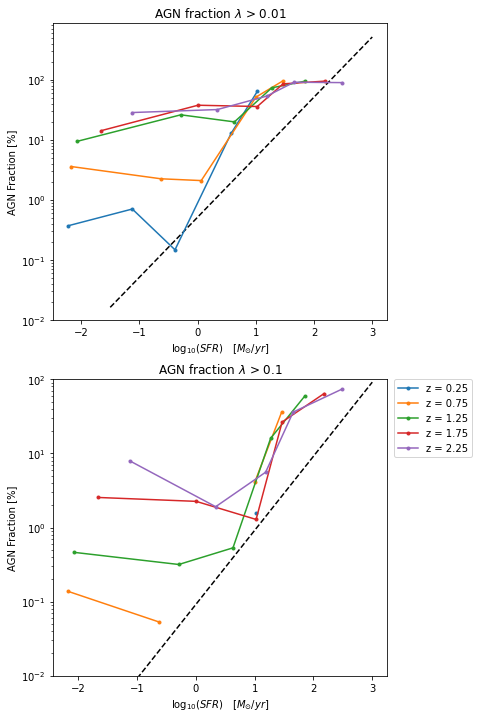

In [69]:
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])

# equations 5 and 6 line
logy2 = -0.59 + SFR_bins_x
y2 = (10**logy2)*2
#print(y2)
logy1 = -1.34 + SFR_bins_x
y1 = (10**logy1)*2
#print(y1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.plot(SFR_bins_x, y2, '--', color='k')
ax1.plot(SFR_bins[0],  AGN_fracs_gt2[0], linestyle='-', marker='.', label='z = 0.25')
ax1.plot(SFR_bins[1],  AGN_fracs_gt2[1], linestyle='-', marker='.', label='z = 0.75')
ax1.plot(SFR_bins[2],  AGN_fracs_gt2[2], linestyle='-', marker='.', label='z = 1.25')
ax1.plot(SFR_bins[3],  AGN_fracs_gt2[3], linestyle='-', marker='.', label='z = 1.75')
ax1.plot(SFR_bins[4],  AGN_fracs_gt2[4], linestyle='-', marker='.', label='z = 2.25')
#ax1.plot(SFR_bins[5],  AGN_fracs_gt2[5], linestyle='-', marker='.', label='z = 2.75')
#ax1.plot(SFR_bins[6],  AGN_fracs_gt2[6], linestyle='-', marker='.', label='z = 3.50')

ax1.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax1.yaxis.set_label_text('AGN Fraction [%]')
ax1.set_title('AGN fraction $\lambda$ > 0.01')
ax1.set_yscale('log')
ax1.set_ylim(bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)

ax2.plot(SFR_bins_x, y1, '--', color='k')
ax2.plot(SFR_bins[0],  AGN_fracs_gt1[0], linestyle='-', marker='.', label='z = 0.25')
ax2.plot(SFR_bins[1],  AGN_fracs_gt1[1], linestyle='-', marker='.', label='z = 0.75')
ax2.plot(SFR_bins[2],  AGN_fracs_gt1[2], linestyle='-', marker='.', label='z = 1.25')
ax2.plot(SFR_bins[3],  AGN_fracs_gt1[3], linestyle='-', marker='.', label='z = 1.75')
ax2.plot(SFR_bins[4],  AGN_fracs_gt1[4], linestyle='-', marker='.', label='z = 2.25')
#ax2.plot(SFR_bins[5],  AGN_fracs_gt1[5], linestyle='-', marker='.', label='z = 2.75')
#ax2.plot(SFR_bins[6],  AGN_fracs_gt1[6], linestyle='-', marker='.', label='z = 3.50')

ax2.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax2.yaxis.set_label_text('AGN Fraction [%]')
ax2.set_title('AGN fraction $\lambda$ > 0.1')
ax2.set_yscale('log')
ax2.set_ylim(bottom=10**(-2), top=10**2)
#ax2.set_xlim(left=-2, right=1.5)

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()

^^ this is using the boundary conditions from figure 2 as they are ( and with the original dotted line x2)

### After adjusting boundary conditions so they look good


In [70]:
all_r = get_all_r()
z = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.5]

# lists to store the 6 agn fractions (each redshift)
AGN_fracs_gt2 = []
AGN_fracs_gt1 = []

# list to store the 6 sfr bin midpoints for plotting
SFR_bins = []

#iterating across each redshift
for count, key in enumerate(all_r):
    print(key)
    
    #
    AGN_frac_per_bin_gt2 = np.array([])
    AGN_frac_per_bin_gt1 = np.array([])
    
    #extract xray luminosities to make mask Lx> 10^42
    Lx = all_r[key]['Lx']
    sm = all_r[key]['sm']
    logsm = np.log10(sm.data)
    
    # NEW WAY: binning the mass data
    #extracting the sfrs for this redshift
    SFRs_all = all_r[key]['SFR']
    SFRs = SFRs_all
    
    #creating an empty array with the size equal to the amount of 0 sfr values
    rand_sams = np.zeros(SFRs[SFRs == 0].shape)
    
    #filling the empty array with random numbers ranging between 0.000001 and 0.00001
    for i in range(len(rand_sams)):
        rand_sams[i] = np.random.uniform(1e-3, 1e-2)
      
    #replacing 0 sfr values with the randomly sampled low values
    SFRs[SFRs == 0] = rand_sams
    
    #logging the full sfr array with 0 values replaced
    logSFRs = np.log10(np.asarray(SFRs))
    
    #calculating relative MS values
    logSFR_MS = logSFRs + 7.6 - 0.76*logsm - 2.95*np.log10(1+z[count])
    
    #defining bin boundaries
    bins = [np.inf, 0.15, -0.4, -0.95, -np.inf]
    
    #binning data based on relative MS values
    digitized = np.digitize(logSFR_MS, bins)
    
    
    '''
    #sorting the sfrs into ascending order
    sort_logSFR = logSFRs[np.argsort(logSFRs)]
        #print(sort_logSFR)
    #book-keeping the sfr ranges
    print('min: ', true_min, 'max: ', sort_logSFR[-1])

    #binning the sorted sfrs into 5 equal sized bins
    binned_SFR = np.array_split(sort_logSFR, 5)
    #print(binned_SFR)

    #empty arrays for the sfr midpoints and the bin boundaries
    SFRs_midpoints = np.array([])
    bins = np.array([])
    
    #iterating across each bin
    for i in binned_SFR:
        #adding the lower boundary of each bin into the boundary array
        bins = np.append(bins, i[0])
        #adding the sfr median into the midpoints array for plotting
        SFRs_midpoints = np.append(SFRs_midpoints, np.median(i))
    
    print('plot points', SFRs_midpoints)
    # adding the final boundary which is the last value in the last bin
    bins = np.append(bins, binned_SFR[-1][-1])
    print('bin boundaries', bins)
    
        
    
    #adding the specific redshifts sfr plotting points to the sfr plotting points array
    SFR_bins.append(SFRs_midpoints)
    
    
    # binning the unsorted sfr data based on the bin boundaries
    digitized = np.digitize(np.log10(all_r[key]['SFR']), bins)
    '''
    # finding plotting points
    SFRs_midpoints = np.array([])
    
    # iterating across each bin
    for i in range(1, len(bins)):
        print('bin', i)
        # finding the lambdas in a certain bin
        lambdas = np.log10(all_r[key]['lambda'][digitized == i])
        # finding the Lxs in a certain bin
        Lx_binned = Lx[digitized == i]
        # finding the agn fractions (2) for a certain bin
        frac_gt2, frac_gt1 = find_fracs(lambdas, Lx_binned)
        
        #binning sfrs
        sfr_binned = logSFRs[digitized == i]
        SFRs_midpoints = np.append(SFRs_midpoints, np.median(sfr_binned))
        

        #adding the agn fraction of each bin to an array length 5 (no of bins)
        AGN_frac_per_bin_gt2 = np.append(AGN_frac_per_bin_gt2, frac_gt2)
        AGN_frac_per_bin_gt1 = np.append(AGN_frac_per_bin_gt1, frac_gt1)

    #print(AGN_frac_per_bin_gt2, AGN_frac_per_bin_gt1)
    print(np.shape(SFRs_midpoints))
    SFR_bins.append(SFRs_midpoints)
    # adding the certain redshifts agn fraction for each bin, into an array length 6 (no of redshifts)
    AGN_fracs_gt2.append(AGN_frac_per_bin_gt2)
    AGN_fracs_gt1.append(AGN_frac_per_bin_gt1)
    
    
print('agn fracs', AGN_fracs_gt2, AGN_fracs_gt1)
#print('sfr bins', SFR_bins)

yt : [INFO     ] 2023-01-05 14:05:37,564 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_137.hdf5
yt : [INFO     ] 2023-01-05 14:05:37,630 Found 482650 halos
yt : [INFO     ] 2023-01-05 14:05:37,646 Found 49752 galaxies
/home/sarah/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_2157244/2979682850.py:49: RuntimeWarning: divide by zero encountered in log10
  Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
yt : [INFO     ] 2023-01-05 14:05:41,823 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_114.hdf5
yt : [INFO     ] 2023-01-05 14:05:41,888 Found 517907 halos
yt : [INFO     ] 2023-01-05 14:05:41,904 Found 41585 galaxies
yt : [INFO     ] 2023-01-05 14:05:45,247 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_097.hdf5
yt : [INFO     ] 2023-01-05 14:05:45,283 Found 539783 h

z137
bin 1
bin 2
there are no lambdas>0.1
bin 3
there are no lambdas>0.1
bin 4
there are no lambdas>0.1
(4,)
z114
bin 1
bin 2
bin 3
there are no lambdas>0.1
bin 4
(4,)
z097
bin 1
bin 2
bin 3
bin 4
(4,)
z084
bin 1
bin 2
bin 3
bin 4
(4,)
z074
bin 1
bin 2
bin 3
bin 4
(4,)
z066
bin 1
bin 2
bin 3
bin 4
(4,)
z056
bin 1
bin 2
bin 3
bin 4
(4,)
agn fracs [array([41.15456238,  3.72990354,  0.1345895 ,  0.44510386]), array([82.64182896, 39.86519018,  2.45464248,  2.56756757]), array([94.07616361, 68.01215278, 16.89961881, 20.50919378]), array([97.05882353, 83.47107438, 36.74033149, 29.10532276]), array([93.23308271, 90.46345811, 57.50421585, 30.48433048]), array([91.42857143, 92.7140255 , 75.95818815, 33.33333333]), array([85.71428571, 94.11764706, 90.42253521, 61.81818182])] [array([0.46554935,        nan,        nan,        nan]), array([18.71295512,  0.38517092,         nan,  0.06756757]), array([40.62059238, 11.02430556,  0.38119441,  0.47147572]), array([53.92156863, 22.84533648,  0.82872928

/tmp/ipykernel_2157244/494285686.py:95: RuntimeWarning: divide by zero encountered in log10
  lambdas = np.log10(all_r[key]['lambda'][digitized == i])


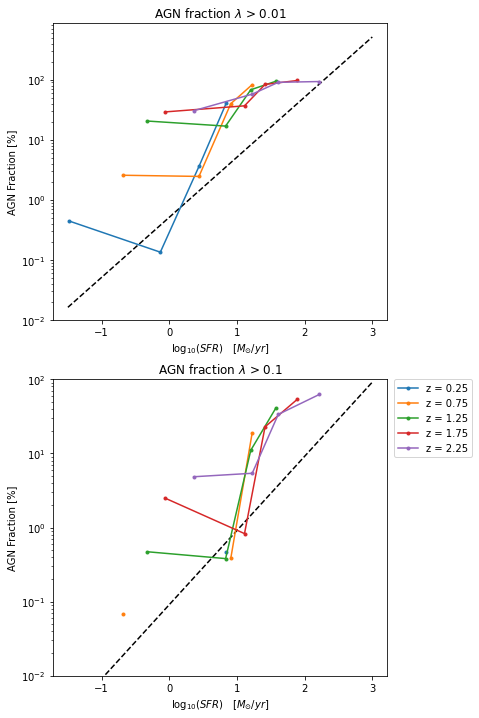

In [71]:
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])

# equations 5 and 6 line
logy2 = -0.59 + SFR_bins_x
y2 = (10**logy2)*2
#print(y2)
logy1 = -1.34 + SFR_bins_x
y1 = (10**logy1)*2
#print(y1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.plot(SFR_bins_x, y2, '--', color='k')
ax1.plot(SFR_bins[0],  AGN_fracs_gt2[0], linestyle='-', marker='.', label='z = 0.25')
ax1.plot(SFR_bins[1],  AGN_fracs_gt2[1], linestyle='-', marker='.', label='z = 0.75')
ax1.plot(SFR_bins[2],  AGN_fracs_gt2[2], linestyle='-', marker='.', label='z = 1.25')
ax1.plot(SFR_bins[3],  AGN_fracs_gt2[3], linestyle='-', marker='.', label='z = 1.75')
ax1.plot(SFR_bins[4],  AGN_fracs_gt2[4], linestyle='-', marker='.', label='z = 2.25')
#ax1.plot(SFR_bins[5],  AGN_fracs_gt2[5], linestyle='-', marker='.', label='z = 2.75')
#ax1.plot(SFR_bins[6],  AGN_fracs_gt2[6], linestyle='-', marker='.', label='z = 3.50')

ax1.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax1.yaxis.set_label_text('AGN Fraction [%]')
ax1.set_title('AGN fraction $\lambda$ > 0.01')
ax1.set_yscale('log')
ax1.set_ylim(bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)

ax2.plot(SFR_bins_x, y1, '--', color='k')
ax2.plot(SFR_bins[0],  AGN_fracs_gt1[0], linestyle='-', marker='.', label='z = 0.25')
ax2.plot(SFR_bins[1],  AGN_fracs_gt1[1], linestyle='-', marker='.', label='z = 0.75')
ax2.plot(SFR_bins[2],  AGN_fracs_gt1[2], linestyle='-', marker='.', label='z = 1.25')
ax2.plot(SFR_bins[3],  AGN_fracs_gt1[3], linestyle='-', marker='.', label='z = 1.75')
ax2.plot(SFR_bins[4],  AGN_fracs_gt1[4], linestyle='-', marker='.', label='z = 2.25')
#ax2.plot(SFR_bins[5],  AGN_fracs_gt1[5], linestyle='-', marker='.', label='z = 2.75')
#ax2.plot(SFR_bins[6],  AGN_fracs_gt1[6], linestyle='-', marker='.', label='z = 3.50')

ax2.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax2.yaxis.set_label_text('AGN Fraction [%]')
ax2.set_title('AGN fraction $\lambda$ > 0.1')
ax2.set_yscale('log')
ax2.set_ylim(bottom=10**(-2), top=10**2)
#ax2.set_xlim(left=-2, right=1.5)

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()

In [73]:
from json import load
from sys import argv

def loc(nb):
    cells = load(open(nb))['cells']
    return sum(len(c['source']) for c in cells if c['cell_type'] == 'code')

def run(ipynb_files):
    return sum(loc(nb) for nb in ipynb_files)

if __name__ == '__main__':
    print(run(argv[1:]))

FileNotFoundError: [Errno 2] No such file or directory: '-f'